# Manuscript figures

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import biotite.structure.io.pdb as pdb
import biotite.structure as struc
import numpy as np
import joblib
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.lines import Line2D
from matplotlib.patches import Circle, FancyArrowPatch
import matplotlib.patches as mpatches 
from matplotlib.collections import PatchCollection
import matplotlib.gridspec as gridspec
from Bio import SeqIO
import warnings
from Bio import BiopythonParserWarning
warnings.simplefilter('ignore', BiopythonParserWarning)

In [2]:
# Helper functions

MAX_ASA = { "rost_sander": { "LYS": 205, "ASP": 163, "GLU": 194, "ASN": 157 }}
def getASA(row) -> float:
    """
    
        Calculates rASA of isopep residues. Returns average value. Use mash points == 100 to speed up computation
    
    """
    rASA = np.NaN
    struct_path = row["structure_path"]
    chain = row["chain"]
    r1, r2, r3 = [int(i) for i in row["match_residues"].split("_")]
    #struct_path = os.path.join(PDB_DIR, f"{protein}.pdb")
    pdb_file = pdb.PDBFile.read(struct_path)
    # Exclude water
    structure = struc.array([atom for atom in pdb_file.get_structure()[0] if atom.hetero==False and atom.chain_id==chain])
    # Consider whole structure to calculate sASA
    try:
        structure_sasa = struc.sasa(structure, point_number=500)
        # Get indeces
        r1_indx = [i for i, atom in enumerate(structure) if atom.res_id == r1]
        r2_indx = [i for i, atom in enumerate(structure) if atom.res_id == r2]
        r3_indx = [i for i, atom in enumerate(structure) if atom.res_id == r3]

        r1_aa = structure[r1_indx[0]].res_name
        r2_aa = structure[r2_indx[0]].res_name
        r3_aa = structure[r3_indx[0]].res_name
        
        r1_asa = sum([structure_sasa[i] for i in r1_indx]) / MAX_ASA["rost_sander"][r1_aa]
        r2_asa = sum([structure_sasa[i] for i in r2_indx]) / MAX_ASA["rost_sander"][r2_aa]
        r3_asa = sum([structure_sasa[i] for i in r3_indx]) / MAX_ASA["rost_sander"][r3_aa]
        
        rASA = [r1_asa, r2_asa, r3_asa]
        
    except IndexError:
        ""
        rASA = np.NaN
        
    except KeyError:
        rASA = np.NaN

    return rASA

def surroundingAtom(source_atom:np.array, structure_array:list, treshold:float) -> list:
    """

        Find structure atoms within trehold distance in amstrongs from given atom

        PARAMETERS
        ----------
        source_atom: np.array:
        structure_array:list
        treshold:float

        RETURN
        ------
        resi_below_treshold:list: list of residues below given treshold
        
    """
    distances = struc.distance(source_atom, structure_array)
    indeces_below_treshold = [pair[0] for pair in enumerate(distances) if pair[1] <= treshold]
    resi_below_treshold = [pair[1] for pair in enumerate(structure_array) if pair[0] in indeces_below_treshold]

    return resi_below_treshold

def get_sequence(row, pdb = True)->str:
    """

        Get sequence from structure. Consider +-20 amino acids from 
        first and last isopeptide bond amino acid
    
    """
    structure_path = row["structure_path"]
    if pdb:
        r1 = row["Position 1\r\n(Bond 1)"]
        r2 = row["Position 2\r\n(catalytic)"]
        r3 = row["Position 3\r\n(Bond 2)"]
    else:
        r1 = row["r1_af"]
        r2 = row["r2_af"]
        r3 = row["r3_af"]
    seq_start = min([r1, r2, r3])
    seq_end = max([r1, r2, r3])
    sequence = list(SeqIO.parse(structure_path, "pdb-atom"))[0]
    # Adjust seq start and end based on pdb seq structure start and end
    pdb_start = sequence.annotations["start"]
    seq_start = seq_start - pdb_start - 20
    seq_end = seq_end - pdb_start + 20
    if seq_start < 0:
        seq_start = 0
    return str(sequence.seq)[seq_start:seq_end]

In [3]:
from dotenv import load_env
load_env("../.env")
TABLE = os.getenv("TABLE")
PDB_DATA_TABLE = "output/pdb_biochem_properties.csv"
AF_DATA_TABLE = "output/af2_templates_biochem_properties.csv"
IDENTITY_TABLE = "tmp/aligned.csv"
STRUCTURE_PATHS = "output/input_files/set3/structures"
FIGURES = "output/figures"
CLF = joblib.load("output/model.pkl")
INPUT_FIGURES = "data/input_figures"

# Info table
df = pd.read_csv(TABLE)
df["deposition_date"] = pd.to_datetime(df["deposition_date"])
# If any bond has been fixed, change its status
df.loc[df["Fixed"] == True, "Assigned bond"] = False
# Assign path
path_df = pd.read_csv(STRUCTURE_PATHS, names=["path"]).drop_duplicates()
path_df["PDB code"] = path_df["path"].apply(lambda x: x.split("/")[-1].split("_")[0])
df = pd.merge(df, path_df, how="left")
df["id"] = df.apply(lambda x: f"{x['PDB code']}_{x['Chain']}_"+
                    "_".join( 
                        [str(i) for i in sorted(
                            [
                            x["Position 1\r\n(Bond 1)"],
                            x["Position 2\r\n(catalytic)"],
                            x["Position 3\r\n(Bond 2)"]
                            ]
                            )]
                            ), axis=1)
# Identity data
identity_df = pd.read_csv(IDENTITY_TABLE)
# Make it reciprocal
identity_df = pd.concat([identity_df, identity_df.rename(columns={"Query":"Target", "Target":"Query"})])

# Biophysical data table
dt_df = pd.read_csv(PDB_DATA_TABLE)
af_df = pd.read_csv(AF_DATA_TABLE)

# Get isopep sequence (+-20 amino acids)
dt_df["isopep_sequence"] = dt_df.apply(get_sequence, pdb=True, axis=1)
af_df["isopep_sequence"] = af_df.apply(get_sequence, pdb=False, axis=1)

# Add cis
dt_df["cis"] = False
dt_df.loc[(dt_df["pseudo_omega"]>=-60)&(dt_df["pseudo_omega"]<60), "cis"] = True

FileNotFoundError: [Errno 2] No such file or directory: 'output/model.pkl'

In [ ]:
# Jess scan table on training set
CACHE_RESULT_TABLE = "output/model_v2/set3.csv"
CACHED_ASA_TABLE = "tmp/set3_cached_asa.csv"
res_df = pd.read_csv(CACHE_RESULT_TABLE)

In [ ]:
# Isopeptide bond surroundings
AMINO_MAPPER = {'GLY': 'Hydrophobic', 'PRO': 'Hydrophobic', 'ALA': 'Hydrophobic', 'LEU': 'Hydrophobic', 'VAL': 'Hydrophobic',
                'ILE': 'Hydrophobic', 'MET': 'Hydrophobic', 'PHE': 'Hydrophobic', 'TRP': 'Hydrophobic', 'THR': 'Polar',
                'TYR': 'Hydrophobic', 'CYS': 'Polar', 'HIS': 'Polar', 'SER': 'Polar', 'ASN': 'Polar',
                'GLN': 'Polar', 'ARG': 'Charged', 'LYS': 'Charged', 'ASP': 'Charged', 'GLU': 'Charged'}

outlist = []
backbone = ["CA", "C", "N", "O"]
cond1 = (df["Is bonded"] == True)
cond2 = (df["Interchain"] == False)
cond3 = (df["Bad rotamer"] == False)
for _, row in df[cond1&cond2&cond3][["PDB code", "Chain", "path"]].drop_duplicates().iterrows():
    pdb_id = row["PDB code"]
    chain = row["Chain"]
    protein = f"{pdb_id}_{chain}"
    struct_path = row["path"]
    try:
        pdb_file = pdb.PDBFile.read(struct_path)
    except FileNotFoundError:
        continue
    # Exclude water and consider the right chain
    structure = struc.array([atom for atom in pdb_file.get_structure()[0] if atom.hetero==False and atom.chain_id == chain])
    # Iterate over each isopep bond
    for _, row2 in df[(df["PDB code"] == pdb_id) & (df["Chain"] == chain)].iterrows():
        r1 = row2["Position 1\r\n(Bond 1)"]
        r2 = row2["Position 2\r\n(catalytic)"]
        r3 = row2["Position 3\r\n(Bond 2)"]
        r1_aa = row2["Residue 1"]
        r2_aa = row2["Residue 2"]
        r3_aa = row2["Residue 3"]
        isopep = f"{r1}_{r2}_{r3}"
        try:
            
            source_i = [i for i, atom in enumerate(structure) if atom.res_id in [r1, r2, r3] \
                                                 and atom.atom_name == "NZ"]
            source = structure[source_i]
            # Exclude backbone atoms
            target = struc.array([atom for atom in structure if atom.res_id not in [r1, r2, r3] and atom.atom_name not in backbone])
            res_below_treshold = surroundingAtom(source, target, 5)
            
            unique_residues = set([(atom.res_id, atom.res_name) for atom in res_below_treshold])
            for res in unique_residues:
                outlist.append([pdb_id, chain, r1, res[0], res[1]])
        except ValueError as e:
            ""
s_df = pd.DataFrame(outlist, columns=["PDB code", "Chain", "Position 1\r\n(Bond 1)", "res_index", "res_type"])
s_df = pd.merge(s_df, df, on=["PDB code", "Chain", "Position 1\r\n(Bond 1)"])
s_df = pd.merge(s_df, dt_df[["PDB code", "Chain", "Position 1\r\n(Bond 1)", "isopep_sequence"]])

In [ ]:
# Get template/hmm-based AFDB scans

str_df = pd.read_csv("output/20241030_AFDBScan.csv", low_memory=False).replace('ND', np.NaN)
hmm_df = pd.read_csv("output/20241029_HMMScan.csv", low_memory=False)

In [ ]:
# Whole set of domains from template/hmm-based methods

strd_df = pd.read_csv("tmp/cached_domains.csv")
hmmd_df = pd.read_csv("tmp/hmm_domains.csv")

In [ ]:
non_isopep = ["Metallophos", "FAD_oxidored", "CBM_21", "DAO", "CarboxypepD_reg", "NHL", "Peptidase_C25", "Molybdopterin"]
isopep = ['DUF7507', 'SpaA', 'GramPos_pilinBB', 'DUF11', 'GramPos_pilinD1', 'Cna_B', 'Collagen_bind', 'DUF7619', 'AgI_II_C2',
         'Sgo0707_N2', 'DUF7604', 'Antigen_C', 'DUF7617', 'DUF5979', 'SpaA_3', 'SpaA_4', 'GramPos_pilinD3', 'SdrD_B',
         'SpaA_2', 'FctA', 'DUF7601', 'GBS104-like_Ig']

In [ ]:
# plot params
mpl.rcParams['font.size'] = 15
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.labelweight'] = 'normal'
mpl.rcParams['axes.titlesize'] = 25
mpl.rcParams['axes.titleweight'] = 'normal'
# size of letters that specify images
ANNOT_FONT_SIZE = 50

## Figure 2

NameError: name 'df' is not defined

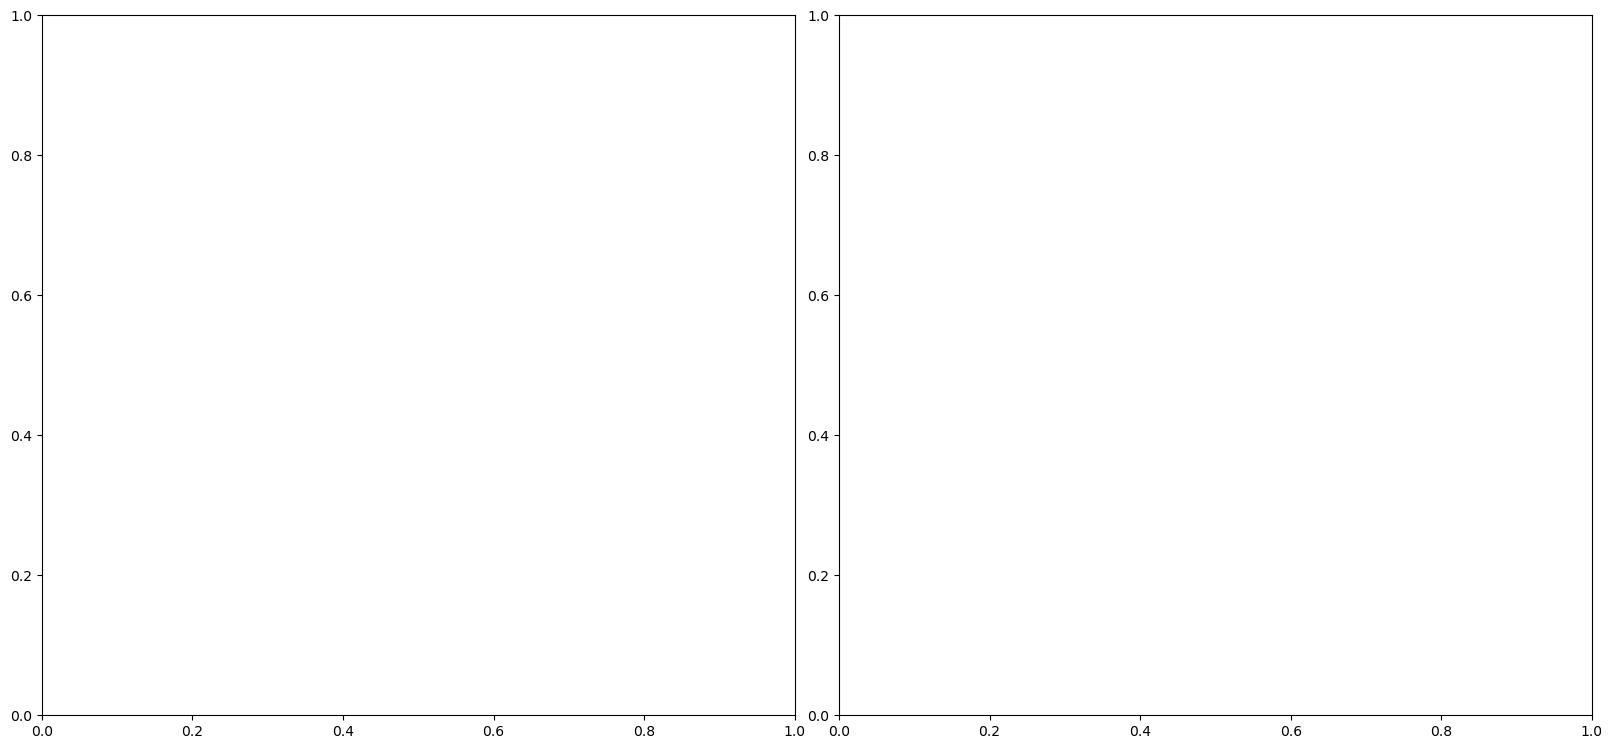

In [4]:
fig = plt.figure(figsize=[20, 20])
gs = gridspec.GridSpec(nrows=2, ncols=6, figure=fig, width_ratios=[1, 1, 1, 1, 1, 1 ])

# Make plots spanning multiple axes
ax1 = fig.add_subplot(gs[0, :3])
ax2 = fig.add_subplot(gs[0, 3:])

# 1
ax = ax1
plot_df = df[df["Is bonded"] == True].copy()
plot_df["correct_geo_or_asgn"] = True
plot_df.loc[(plot_df["Fixed"]==True)|(plot_df["Bad rotamer"]==True), "correct_geo_or_asgn"] = False
g=sns.ecdfplot(data=plot_df, palette="Paired", 
      x="deposition_date", stat="count", hue="correct_geo_or_asgn", ax=ax, lw=4)
ax.legend(labels=["Modelled with isopeptide bond", "Modelled without isopeptide bond"], frameon=False)
sns.move_legend(g, (.15, .9))
labels = [t.get_text() for t in ax.get_xticklabels()]
positions = [t.get_position()[0] for t in ax.get_xticklabels()]
ax.set_xticks(positions, labels)
ax.set_ylim([0,200])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Deposition date")
ax.set_ylabel("Cumulative count")
sns.despine(ax=ax, offset=20)

# 2 
ax = ax2
ax.axis("off")
ax.set_xticks([], [])
ax.set_yticks([], [])
ax.set_aspect('equal')

# im 1
arr_img = plt.imread(os.path.join(INPUT_FIGURES, "7k1u_307_399_449_cut.png"))
im = OffsetImage(arr_img, zoom=.2)
ab = AnnotationBbox(im, xy=(0, 0), xybox=(-.1, .5), box_alignment=(0, 0), bboxprops=dict(color="white"))
ax.add_artist(ab)
# Arrow
start = (0.444, .767)
end = (0.55, 0.75)

style = "Fancy,tail_width=0.1,head_width=10,head_length=20"
kw = dict(arrowstyle=style, color="gray", linewidth=2)
a1 = FancyArrowPatch(start, end, alpha=1,
                     connectionstyle="arc3,rad=0.3",
                     transform=fig.transFigure,
                     **kw)
point = Circle(start, 0.004, transform=fig.transFigure, color="grey", zorder=100)

fig.patches.append(a1)
fig.patches.append(point)
# Annots
ax.text(x=0.13,y=.45,s="PDB ID: 7K1U, chain: A")
ax.text(x=0.11,y=.75,s="K307")
ax.text(x=0.265,y=.65,s="D449")
ax.text(x=0.32,y=.85,s="E399")

# Add circle
palette = sns.color_palette("Paired", 2)
c1 = mpl.patches.Circle((.285,.735), .24, color=palette[1], fill=False, zorder=10, lw=3.5)
ax.add_patch(c1)

# im 2
arr_img = plt.imread(os.path.join(INPUT_FIGURES, "2x9y_349_405_428_cut.png"))
im = OffsetImage(arr_img, zoom=.2)
ab = AnnotationBbox(im, xy=(0, 0), xybox=(0.1, -.1), box_alignment=(0, 0), bboxprops=dict(color="white"))
ax.add_artist(ab)
start = (0.32, 0.5605)
end = (0.62, 0.64)
style = "Fancy,tail_width=0.1,head_width=10,head_length=20"
kw = dict(arrowstyle=style, color="gray", linewidth=2)
a1 = FancyArrowPatch(start, end, alpha=1,
                     connectionstyle="arc3,rad=-0.3",
                     transform=fig.transFigure,
                     **kw)
point = Circle(start, 0.004, transform=fig.transFigure, color="grey", zorder=100)

fig.patches.append(a1)
fig.patches.append(point)
ax.text(x=0.32,y=-.15,s="PDB ID: 2X9Y, chain: A")
ax.text(x=0.3,y=.1,s="K349")
ax.text(x=0.36,y=.2,s="E405")
ax.text(x=0.53,y=.115,s="N428")

# Add circle
palette = sns.color_palette("Paired", 2)
c1 = mpl.patches.Circle((.485,.145), .24, color=palette[0], fill=False, zorder=1000, lw=3.5, clip_on=False)
ax.add_patch(c1)

# im 3 
arr_img = plt.imread(os.path.join(INPUT_FIGURES, "1amx_A_176_209_293_cut.png"))
im = OffsetImage(arr_img, zoom=.1)
ab = AnnotationBbox(im, xy=(0, 0), xybox=(-1.15, .39), box_alignment=(0, 0), bboxprops=dict(color="white"))
ax.add_artist(ab)
# Arrow
start = (0.15, .533)
end = (0.17, 0.69)

style = "Fancy,tail_width=0.1,head_width=10,head_length=20"
kw = dict(arrowstyle=style, color="gray", linewidth=2)
a1 = FancyArrowPatch(start, end, alpha=1,
                     connectionstyle="arc3,rad=-0.3",
                     transform=fig.transFigure,
                     **kw)
point = Circle(start, 0.004, transform=fig.transFigure, color="grey", zorder=100)

fig.patches.append(a1)
fig.patches.append(point)

# Annots
ax.text(x=-1,y=.35,s="PDB ID: 1AMX, chain: A")
ax.text(x=-.8,y=.5,s="K176", zorder=100)
ax.text(x=-.8,y=.67,s="D209", zorder=1000)
ax.text(x=-1.05,y=.6,s="N293", zorder=1000)

# Add circle
palette = sns.color_palette("Paired", 2)
c1 = mpl.patches.Circle((-.825,.645), .235, color=palette[0], fill=False, zorder=1000, lw=3.5, clip_on=False)
ax.add_patch(c1)

#plt.savefig(os.path.join(FIGURES, "f2.png"), dpi=350, bbox_inches="tight", pad_inches=0, transparent=False)

## Figure 4

In [45]:
def draw_self_loop(center, radius, facecolor="Black", edgecolor='Black', theta1=-60, theta2=180, rotation=90):
    """ Adapted from https://naysan.ca/2020/07/04/how-to-draw-an-arrow-that-loops-with-matplotlib/"""
    
    # Add the ring (arc)
    rwidth = 0.005
    ring = mpatches.Wedge(center, radius, theta1, theta2, width=rwidth)
    
    # Calculate arrow cap position based on theta2
    theta2_rad = np.radians(theta2)  # Convert theta2 to radians
    x_end = center[0] + radius * np.cos(theta2_rad)
    y_end = center[1] + radius * np.sin(theta2_rad)
    
    # Convert rotation parameter to radians and add it to theta2 for the arrow orientation
    rotation_rad = np.radians(rotation)
    arrow_angle = theta2_rad + rotation_rad
    
    # Define the triangle cap at the end of the arc, with additional rotation
    offset = 0.02  # Width of the arrow cap
    left = [x_end - offset * np.cos(arrow_angle + np.pi/2), y_end - offset * np.sin(arrow_angle + np.pi/2)]
    right = [x_end + offset * np.cos(arrow_angle + np.pi/2), y_end + offset * np.sin(arrow_angle + np.pi/2)]
    bottom = [x_end + 0.05 * np.cos(arrow_angle), y_end + 0.05 * np.sin(arrow_angle)]
    arrow = plt.Polygon([left, right, bottom, left])
    
    # Add both the arc and arrow cap to a PatchCollection
    p = PatchCollection(
        [ring, arrow], 
        edgecolor=edgecolor, 
        facecolor=facecolor,
        zorder=100,
        clip_on=False
    )
    ax.add_collection(p)

In [46]:
# Get rama plot from N structures
import biotite.structure.io as strucio

phi, psi, omega = [], [], []
for structure_path in os.listdir("output/Negative_control")[:500]:
    atom_array = strucio.load_structure(os.path.join("output/Negative_control", structure_path))
    try:
        tmp_phi, tmp_psi, tmp_omega = struc.dihedral_backbone(atom_array[atom_array.chain_id == "A"])
        # Conversion from radians into degree
        tmp_phi *= 180 / np.pi
        tmp_psi *= 180 / np.pi
        # Remove invalid values (NaN) at first and last position
        tmp_phi = tmp_phi[1:-1]
        tmp_psi = tmp_psi[1:-1]

        phi.extend(tmp_phi)
        psi.extend(tmp_psi)
        omega.extend(tmp_omega)
    except:
        continue

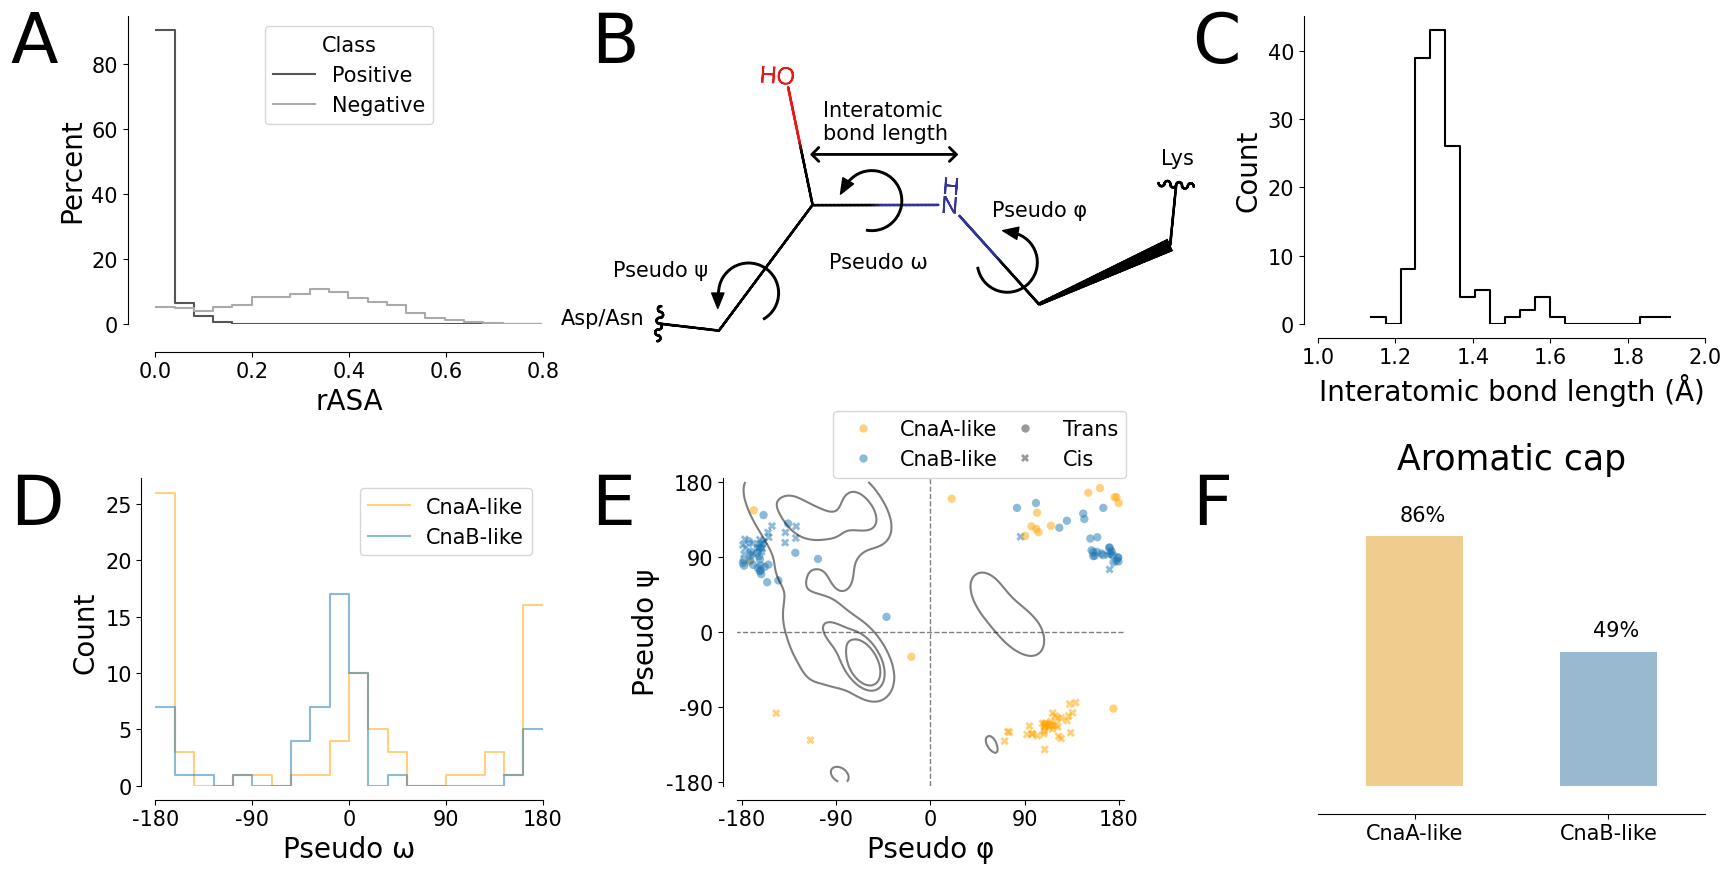

In [47]:
fig = plt.figure(figsize=[20, 10])
gs = gridspec.GridSpec(nrows=2, ncols=3, figure=fig, width_ratios=[1, 1, 1])

# Make plots spanning multiple axes
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[1, 0])
ax5 = fig.add_subplot(gs[1, 1])
ax6 = fig.add_subplot(gs[1, 2])

# 1
ax = ax1
plot_df = res_df[~res_df["mean_rASA"].isna()].sort_values("rmsd").drop_duplicates(["match_id"], keep="first")
# This is a duplicate, remove
plot_df = plot_df[~((plot_df["target"]=="5dz9_A")&(plot_df["template"]=="4z1p_A"))]
plot_df = plot_df[~((plot_df["target"]=="4z1p_A")&(plot_df["template"]=="5dz9_A"))]

sns.histplot(plot_df, x="mean_rASA", hue="true_positive", alpha=1, element="step",
             fill=False, common_norm=False, stat="percent", ax=ax, bins=20, palette="binary")
ax.set_xlabel("rASA")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(title='Class', labels=['Positive', 'Negative'], loc="upper center")
#ax.set_ylim([0, 70])
ax.set_xlim([0,.8])
sns.despine(ax=ax, offset=20)

# 2
ax = ax2
ax.axis("off")
# Image of isopep bond
arr_img = plt.imread(os.path.join(INPUT_FIGURES, "isopepbond_cleaned.png"))
# Rotate
#arr_img = ndimage.rotate(arr_img, -3.8)
im = OffsetImage(arr_img, zoom=.2)
ab = AnnotationBbox(im, xy=(0, 0), xybox=(-0.44, -0.55), box_alignment=(0, 0), bboxprops=dict(color="white"))
ax.add_artist(ab)

# Curved arrows and annot
ax.set_aspect('equal')
draw_self_loop(center=(-0.09, .1), radius=.1, theta1=-60, theta2=180)
draw_self_loop(center=(.31, .4), radius=.1, theta1=-100, theta2=140, rotation=100)
draw_self_loop(center=(.75, .2), radius=.1, theta1=-170, theta2=70, rotation=100)
ax.text(x=-.53, y=.155, s="Pseudo ψ")
ax.text(x=.17, y=.18, s="Pseudo ω")
ax.text(x=.7, y=.35, s="Pseudo φ")

# Bond len arrow
start_point = (0.1, 0.55)
end_point = (0.6, 0.55)
arrow = FancyArrowPatch(start_point, end_point, color="black", linewidth=2, arrowstyle="<->,head_width=5,head_length=5", 
                        zorder=10, ls="-")
ax.add_patch(arrow)
ax.text(x=.15, y=.6, s="Interatomic\nbond length", rotation=0)

# Other text
ax.text(x=-.7, y=.0, s="Asp/Asn")
ax.text(x=1.25, y=.52, s="Lys")

# 3
ax = ax3
sns.histplot(data=dt_df[dt_df["resolution"]<=2.5], x="bond_length", ax=ax, element="step", bins=20, fill=False, color="black")
ax.set_xlabel("Interatomic bond length (Å)")
ax.set_xlim([1, 2])
sns.despine(offset=10, ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# 4
ax = ax4
sns.histplot(data=dt_df[(dt_df["Isopeptide type (see notes)"]!="Mutant")&(dt_df["resolution"]<=2.5)], 
             x="pseudo_omega", ax=ax, fill=False, element="step", bins=20, hue="Isopeptide type (see notes)", 
             alpha=.5, palette=["C0", "orange"])
ax.legend(title="", labels=["CnaA-like", "CnaB-like"])
ax.set_xlabel("Pseudo ω")
ax.set_xlim([-180, 180])
ax.set_xticks([-180, -90, 0, 90, 180], [-180, -90, 0, 90, 180])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
sns.despine(offset=10, ax=ax)

# 5
ax = ax5
sns.scatterplot(data=dt_df[(dt_df["Isopeptide type (see notes)"]!="Mutant")&(dt_df["resolution"]<=2.5)], 
                x="pseudo_phi", y="pseudo_psi", hue="Isopeptide type (see notes)", alpha=.5, ax=ax,
                style="cis", lw=0, palette=["orange", "C0"])
# Ramachandran plot overlayed
sns.kdeplot(x=phi, y=psi, alpha=.5, color="black", ax=ax, cut=0, levels=4)
ax.axvline(0, -181, 181, linewidth=1, color="black", ls="--", alpha=.5)
ax.axhline(0, -181, 181, linewidth=1, color="black", ls="--", alpha=.5)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:3]+handles[-2:], 
            labels=["CnaA-like", "CnaB-like", "Trans", "Cis"],
            columnspacing = .3,
            loc=[0.25,1],
            ncols=2) # <---------------------------------------------------------------
ax.set_xlim([-185, 185])
ax.set_ylim([-185, 185])
ax.set_xticks([-180, -90, 0, 90, 180], [-180, -90, 0, 90, 180])
ax.set_yticks([-180, -90, 0, 90, 180], [-180, -90, 0, 90, 180])
ax.set_xlabel("Pseudo φ")
ax.set_ylabel("Pseudo ψ")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
sns.despine(offset=10, ax=ax)

# 6
# Adopt some approximate values since I am not considering hydrogens
# max pi-H distance + C-H distance
ax = ax6
dist_cutoff = 4.3+1.09
angle_cutoffs = [80, 100]
plot_df = dt_df.drop_duplicates("isopep_sequence").copy()
plot_df["Aromatic cap"] = True
plot_df.loc[(plot_df["distance_to_aro"]>dist_cutoff)&\
    ((plot_df["angle_with_aro"]<angle_cutoffs[0])|(plot_df["angle_with_aro"]>angle_cutoffs[1])), "Aromatic cap"] = False
cond1 = (plot_df["Is bonded"] == True)
cond2 = (plot_df["Interchain"] == False)
cond3 = (plot_df["Bad rotamer"] == False)
cond4 = (plot_df["Isopeptide type (see notes)"]!="Mutant")
plot_df = plot_df[cond1&cond2&cond3&cond4].groupby(["Isopeptide type (see notes)"])\
    .value_counts(["Aromatic cap"], normalize=True).reset_index()
plot_df["Percent"] = plot_df["proportion"].mul(100)

plot_df_2 = plot_df[plot_df["Aromatic cap"]==True].pivot(columns="Aromatic cap", values="Percent", index="Isopeptide type (see notes)")\
    .reindex(columns=[True], level="first")
sns.barplot(data=plot_df_2, y=True, x="Isopeptide type (see notes)", ax=ax, hue="Isopeptide type (see notes)",
            legend=False, palette=["orange", "C0"], alpha=.5, width=.5)

# Annot
y = plot_df[(plot_df["Aromatic cap"]==True)&(plot_df["Isopeptide type (see notes)"]=="CnaA-like")]["Percent"].iloc[0] + 5
ax.text(x=0-.08, y=y, s=f"{round(y)}%")
y = plot_df[(plot_df["Aromatic cap"]==True)&(plot_df["Isopeptide type (see notes)"]=="CnaB-like")]["Percent"].iloc[0] + 5
ax.text(x=1-.08, y=y, s=f"{round(y)}%")

ax.set_ylim([0,100])
ax.set_title("Aromatic cap")
ax.set_xlabel("")
ax.set_ylabel("")
plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
sns.despine(ax=ax, offset=20, left=True)
ax.set_yticks([],[])
#ax.legend(loc="upper center", title="Aromatic cap")

plt.subplots_adjust(hspace=.5, wspace=.5)

plt.text(-7.25,235, "A", fontsize=ANNOT_FONT_SIZE)
plt.text(-4.25,235, "B", fontsize=ANNOT_FONT_SIZE)
plt.text(-1.15,235, "C", fontsize=ANNOT_FONT_SIZE)
plt.text(-7.25,85, "D", fontsize=ANNOT_FONT_SIZE)
plt.text(-4.25,85, "E", fontsize=ANNOT_FONT_SIZE)
plt.text(-1.15,85, "F", fontsize=ANNOT_FONT_SIZE)

plt.savefig(os.path.join(FIGURES, "f4.png"), dpi=350, bbox_inches="tight", pad_inches=0)

## Figure 5

In [10]:
import sys
sys.path.append("bin")
from pfamenv import PFAM_USER, PFAM_HOST, PFAM_PASSWORD, PFAM_PORT
from mysql import connector
from matplotlib_venn import venn2

def domain(pfamA_accs:list) -> pd.DataFrame:
    """
        Maps pfamA_acc to pfamA_id
    
    
    """
    cnx = connector.connect(user=PFAM_USER,
                            password=PFAM_PASSWORD,
                            port=PFAM_PORT,
                            host=PFAM_HOST)
    cursor = cnx.cursor()
    pfamA_accs = ",".join([f"'{u}'" for u in pfamA_accs])
    # For this use the most recent pfam
    cursor.execute(f"SELECT pfamA_acc, pfamA_id FROM pfam_37_0.pfamA\
                WHERE pfamA_acc IN ({pfamA_accs})")

    output = cursor.fetchall()

    return(pd.DataFrame(output, columns=["pfamA_acc", "pfamA_id"]))
# All domains from IB-containing proteins, excluding IB-containing domains
ib_proteins = str_df[(str_df["prob"]>.5)&(~str_df["taxonomy"].isna())]["target"].unique()
ib_domains = str_df[(str_df["prob"]>.5)&(~str_df["taxonomy"].isna())]["pfamA_acc"].unique()
d_df_domains = strd_df[(strd_df["pfamseq_acc"].isin(ib_proteins))&(~strd_df["pfamA_acc"].isin(ib_domains))]["pfamA_acc"].unique()
count_df = strd_df[(strd_df["pfamseq_acc"].isin(ib_proteins))&(~strd_df["pfamA_acc"].isin(ib_domains))].value_counts("pfamA_acc").reset_index()
count_df = pd.merge(count_df, domain(count_df["pfamA_acc"].unique()))

# Data for venn diagram
str_uniprot = str_df[(~str_df["taxonomy"].isna())&(str_df["prob"]>.5)]["target"].unique()
hmm_uniprot = hmm_df[(hmm_df["taxonomy"]!="ND")]["uniprot_acc"].unique()
common = [u for u in str_uniprot if u in hmm_uniprot]

In [23]:
domain = "PF17963"
domain_prots = strd_df[strd_df["pfamseq_acc"].isin(ib_proteins)&(strd_df["pfamA_acc"]==domain)]["pfamseq_acc"].unique()
strd_df[(strd_df["pfamseq_acc"].isin(domain_prots))].value_counts("pfamA_acc")

pfamA_acc
PF17963    324
PF17892    181
PF17803    180
PF13585     78
PF01345     67
PF19076     44
PF05737     42
PF18483     15
PF17802     12
PF17961      8
PF18884      7
PF17210      6
PF20009      6
PF19406      6
PF00746      5
PF19081      4
PF18651      3
PF00691      2
PF03160      2
PF00404      1
PF00028      1
PF13205      1
PF08329      1
PF13620      1
PF16130      1
Name: count, dtype: int64

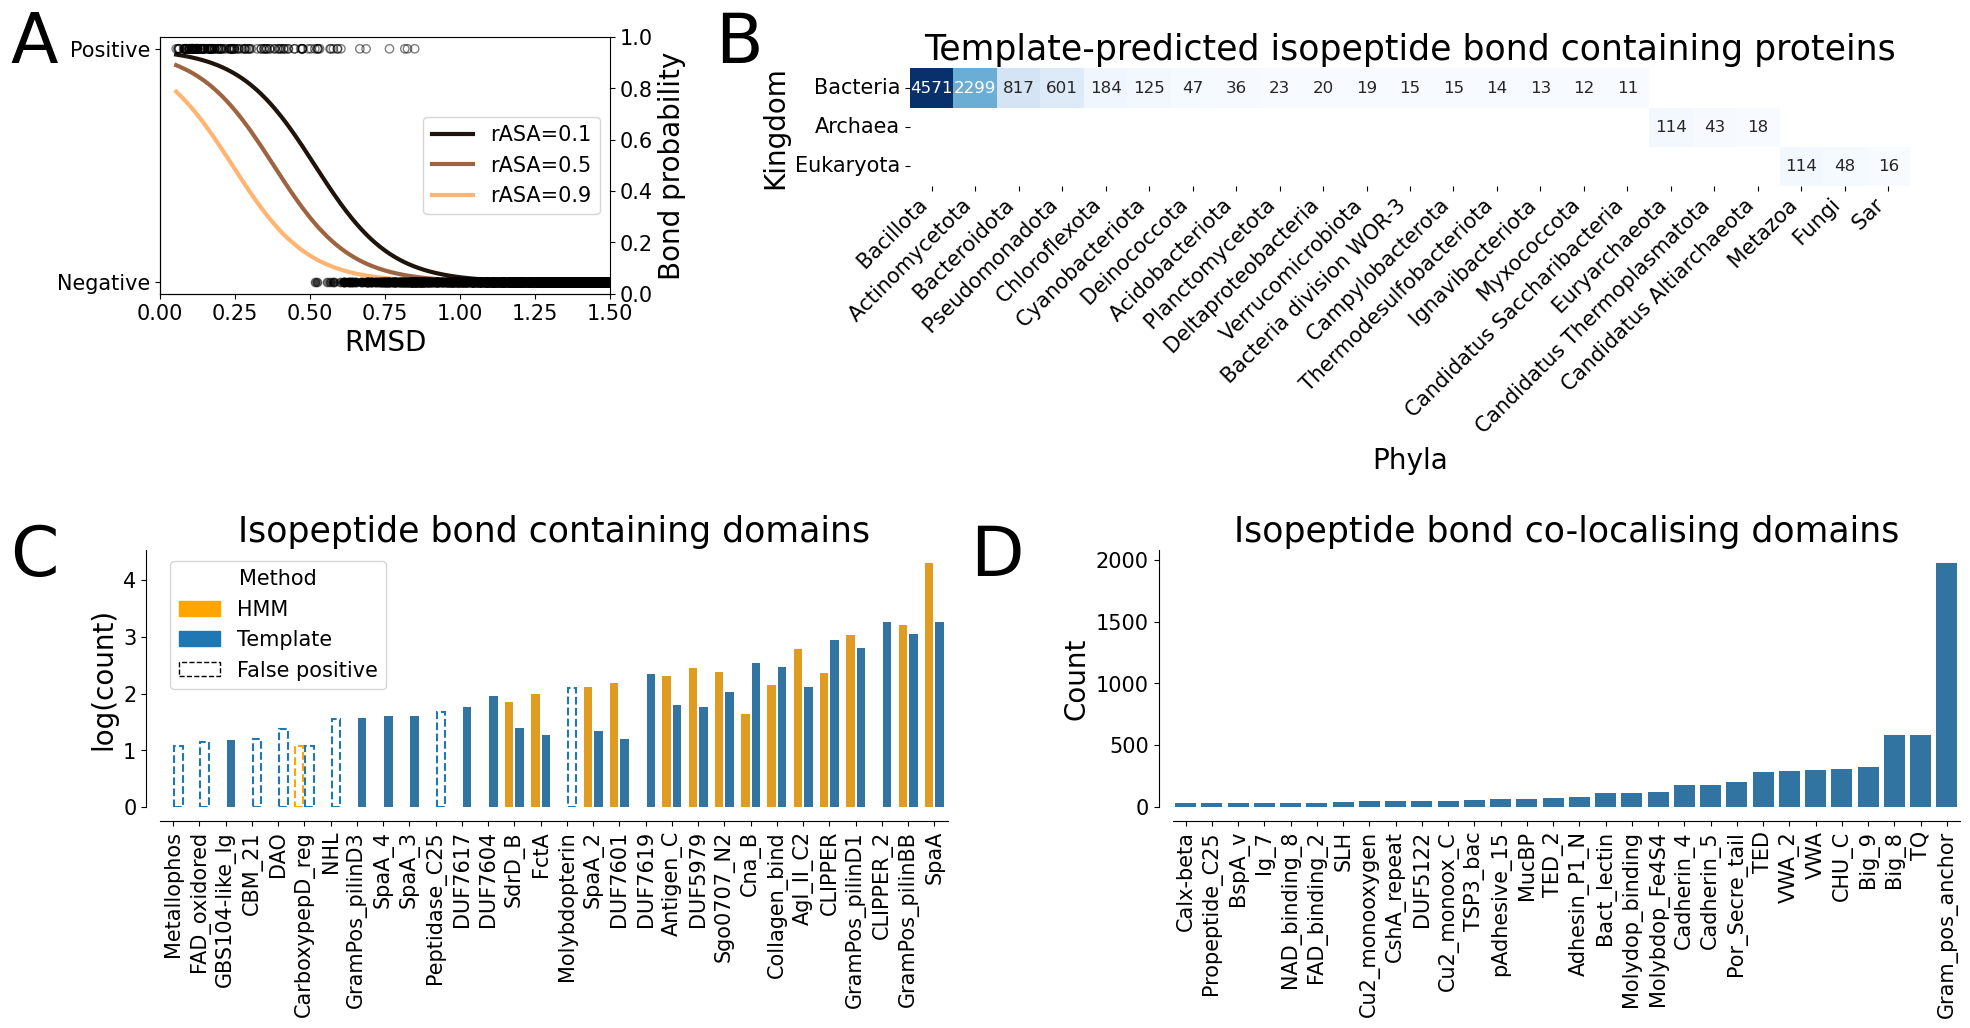

In [11]:
fig = plt.figure(figsize=[20, 10])
gs = gridspec.GridSpec(nrows=2, ncols=6, figure=fig, width_ratios=[1, 1, 1, 1, 1, 1])

ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[0, 2:6])
#ax3 = fig.add_subplot(gs[0, 4:6])
ax4 = fig.add_subplot(gs[1, 0:3])
ax5 = fig.add_subplot(gs[1, 3:6])

# 1
ax = ax1
plot_df = res_df[~res_df["mean_rASA"].isna()].sort_values("rmsd").drop_duplicates(["match_id"], keep="first")
# This is a false neg:
plot_df = plot_df[plot_df["match_id"]!="2X9Y_193_241_318"]

sns.scatterplot(plot_df[plot_df["true_positive"]==1], x="rmsd", y="true_positive", alpha=.5, lw=1, ax=ax, edgecolors="black", 
               facecolors='none')
sns.scatterplot(plot_df[plot_df["true_positive"]==0], x="rmsd", y="true_positive", alpha=.5, lw=1, ax=ax, edgecolors="black", 
               facecolors='black')

copper = plt.get_cmap('copper')
for mean_asa in [0.1, 0.5, 0.9]:
    X =  plot_df.sort_values(["rmsd", "mean_rASA"])[["rmsd", "mean_rASA"]].assign(mean_rASA=mean_asa).to_numpy()
    ax.plot(X[:,0], CLF.predict_proba(X)[:,1], alpha=1, lw=3, ls="-", color=copper(mean_asa), zorder=0,
            label = f"rASA={mean_asa}")
ax.legend(loc="center right")
ax.set_yticks([0, 1])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.legend(title='Class', labels=['Positive', 'Negative'])
ax.set_ylabel("")
ax.set_xlabel("RMSD")
ax.set_yticks([0,1], ["Negative", "Positive"])
ax.set_xlim([0,1.5])

ax_r = ax.twinx()
ax_r.set_ylabel('Bond probability', color="black")
ax_r.tick_params(axis='y', labelcolor="black")

# 3
ax = ax4

plot_df = pd.concat([pd.DataFrame(str_df[(str_df["prob"]>.5)&(~str_df["taxonomy"].isna())].fillna("ND").value_counts(["pfamA_id"])).reset_index()\
                    .query('count>10').assign(Method="Template"),
                    pd.DataFrame(hmm_df[hmm_df["taxonomy"]!="ND"].fillna("ND").value_counts(["pfamA_id"])).reset_index().query('count>10')\
                    .assign(Method="HMM")
                   ]).query('(pfamA_id!="ND")')
plot_df["Pfam domain id"] = plot_df["pfamA_id"].replace({"DUF11":"CLIPPER", "DUF7507":"CLIPPER_2"})
plot_df["Log count"] = plot_df["count"].apply(np.log10)

common_domains = plot_df.value_counts("Pfam domain id").reset_index().query('count==2')["Pfam domain id"].to_list()
plot_df["Detected by"] = "sequence only"
plot_df.loc[(plot_df["Pfam domain id"].isin(common_domains)), "Detected by"] = "both methods"
struct_domains = plot_df[plot_df["Method"]=="Template"]["Pfam domain id"]
plot_df.loc[~(plot_df["Pfam domain id"].isin(common_domains))&\
            (plot_df["Pfam domain id"].isin(struct_domains)), "Detected by"] = "structure only"

order = plot_df.groupby("Pfam domain id").sum("count").reset_index().sort_values("count")["Pfam domain id"]
hue_order = ["HMM", "Template"]

order = plot_df.groupby("Pfam domain id").sum("count").reset_index().sort_values("count")["Pfam domain id"]
hue_order = ["HMM", "Template"]
# Reduce alpha of non IBDs

g=sns.barplot(data=plot_df, x="Pfam domain id", y="Log count",
            palette=["orange", "C0"], hue="Method",
            order=order, dodge=True,
            hue_order=hue_order, ax=ax, legend=False, gap=.2, ls="-", lw=1.5)

# For template-based
fills = [False if domain in non_isopep else True for domain in order]
for bar, fill in zip(ax.containers[1], fills):
    if not fill:
        bar.set_linestyle("--")
        bar.set_color("C0")
        bar.set_fill(fill)

# For HMM
hmm_order = plot_df[plot_df["Method"]=="HMM"].groupby("Pfam domain id").sum("count").reset_index().sort_values("count")["Pfam domain id"]
fills = [False if domain in non_isopep else True for domain in hmm_order]

for bar, fill in zip(ax.containers[0], fills):
    if not fill:
        bar.set_linestyle("--")
        bar.set_color("orange")
        bar.set_fill(fill)

hmm_patch = mpatches.Patch(color='orange', label='HMM')
template_patch = mpatches.Patch(color='C0', label='Template')
false_positive_patch = mpatches.Patch(facecolor='none', edgecolor='black', linestyle='--', label='False positive')
ax.legend(handles=[hmm_patch, template_patch, false_positive_patch], title='Method')

ax.tick_params(axis='x', rotation=90)
sns.despine(ax=ax, offset=10)
ax.set_ylabel("log(count)")
ax.set_xlabel("")
ax.set_title("Isopeptide bond containing domains")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# 4
ax=ax5
g=sns.barplot(count_df.iloc[:30].sort_values("count"), y="count", x="pfamA_id", color="C0", ax=ax)
g.tick_params(axis='x', rotation=90)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
sns.despine(ax=ax, offset=10)
ax.set_xlabel("")
ax.set_title("Isopeptide bond co-localising domains")
ax.set_ylabel("Count")

###############################################
plt.subplots_adjust(hspace=1, wspace=2, left=0, right=.9)
plt.text(-.5,.9, "A", fontsize=ANNOT_FONT_SIZE)
plt.text(1.85,.9, "B", fontsize=ANNOT_FONT_SIZE)
#plt.text(3.5,.85, "C", fontsize=ANNOT_FONT_SIZE)
plt.text(-.5,-1.1, "C", fontsize=ANNOT_FONT_SIZE)
plt.text(2.7,-1.1, "D", fontsize=ANNOT_FONT_SIZE)
################################################

#2
ax = ax2
# Exclude non isopep
plot_df = str_df[(str_df["prob"]>.5)&(~str_df["taxonomy"].isna())].drop_duplicates("target").copy()
plot_df["phyla"] = plot_df["taxonomy"].apply(lambda x: x.split(";")[1].replace(".", "") if len(x.split(";")) >= 2 else np.NaN)
plot_df = plot_df.value_counts(["kingdom", "phyla"]).reset_index()\
                 .query('count>10&kingdom!="unclassified sequences"')\
                 .pivot(index="phyla", columns="kingdom", values="count").fillna(0).astype(int)\
                 [["Bacteria", "Archaea", "Eukaryota"]]\
                 .sort_values(["Bacteria", "Archaea", "Eukaryota"], ascending=[False, False, False]).T
g=sns.heatmap(plot_df, cmap="Blues", ax=ax, mask=(plot_df==0), 
              annot=True, annot_kws={'fontsize':12}, fmt=".0f", cbar=False)
g.set_yticklabels(g.get_yticklabels(), rotation=0)
g.set_xticklabels(g.get_xticklabels(), rotation=45, ha='right')
ax.set_aspect(.9)
ax.set_position(pos=[0.375,.54,.5,.5])
ax.set_title("Template-predicted isopeptide bond containing proteins")
ax.set_ylabel("Kingdom")
ax.set_xlabel("Phyla")

plt.savefig(os.path.join(FIGURES, "f5.png"), dpi=350, bbox_inches="tight", pad_inches=0)

## Figure 6

In [12]:
seq_df = pd.read_csv("tmp/sequence.csv")
c_seq_df = pd.read_csv("tmp/ctrl_sequence.csv")

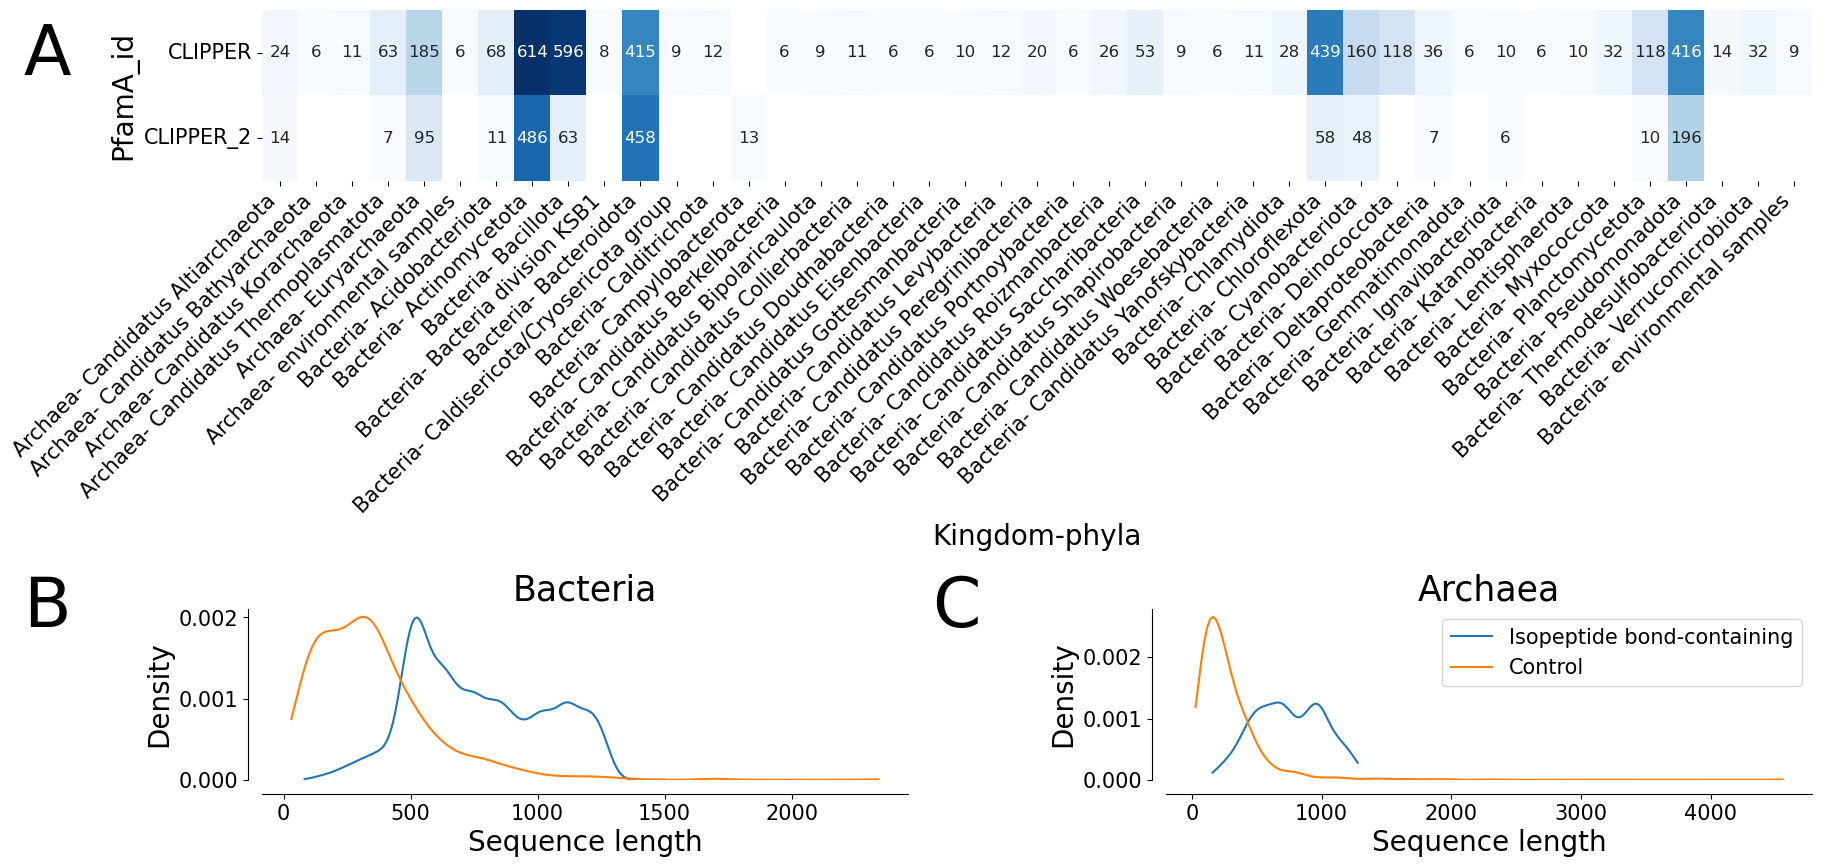

In [14]:

fig = plt.figure(figsize=[20, 10])
gs = gridspec.GridSpec(nrows=2, ncols=2, figure=fig)

ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

plt.subplots_adjust(hspace=2.5, wspace=.4)

# 1
ax = ax1
# Consider clipper domains with the right IB amino acids
plot_df = str_df[(str_df["prob"]>0)&(~str_df["taxonomy"].isna())].drop_duplicates("target").copy()
plot_df["phyla"] = plot_df["taxonomy"].apply(lambda x: x.split(";")[1].replace(".", "") if len(x.split(";")) >= 2 else np.NaN)
plot_df["pfamA_id"] = plot_df["pfamA_id"].replace({"DUF11":"CLIPPER", "DUF7507":"CLIPPER_2"})
plot_df = plot_df.value_counts(["kingdom", "phyla", "pfamA_id"]).reset_index()\
                 .query('count>5&pfamA_id.isin(["CLIPPER", "CLIPPER_2"]) & kingdom != "unclassified sequences"')\
                 .pivot(index=["kingdom", "phyla"], columns="pfamA_id", values="count").fillna(0).astype(int).T

g=sns.heatmap(plot_df, cmap="Blues", ax=ax, mask=(plot_df==0), 
              annot=True, annot_kws={'fontsize':12}, fmt=".0f", cbar=False,
             )

g.set_yticklabels(g.get_yticklabels(), rotation=0)
g.set_xticklabels(g.get_xticklabels(), rotation=45, ha='right')
#ax.set_title("IB containing domains")
ax.set_ylabel("PfamA_id")
ax.set_xlabel("Kingdom-phyla")

# 2,3,4
for ax, kingdom in zip([ax2, ax3], ["Bacteria", "Archaea"]):
    sns.kdeplot(seq_df[seq_df["kingdom"]==kingdom], x="len", label="Isopeptide bond-containing", ax=ax, cut=0)
    sns.kdeplot(c_seq_df[c_seq_df["kingdom"]==kingdom], x="len", label="Control", ax=ax, cut=0)
    ax.set_title(kingdom)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    sns.despine(ax=ax, offset=10)
    ax.set_xlabel("Sequence length")
ax.legend()

plt.text(-9000,0.0115, "A", fontsize=ANNOT_FONT_SIZE)
plt.text(-9000,0.0025, "B", fontsize=ANNOT_FONT_SIZE)
plt.text(-2000,0.0025, "C", fontsize=ANNOT_FONT_SIZE)

plt.savefig(os.path.join(FIGURES, "f6.png"), dpi=350, bbox_inches="tight", pad_inches=0)

##  Figure S2

In [39]:
from sklearn.metrics import auc

In [49]:
# Set1
res_df1 = pd.read_csv("output/model_v2/set1.csv")
res_df1["id"] = res_df1.apply(lambda x: x["target"]+"_"+"_".join(
    [ str(i) for i in 
         sorted(
               [int(i) for i in x["match_residues"].split("_")]
         )
    ]), axis=1)

res_df1 = pd.merge(res_df1, df[["id", "Bad rotamer"]], how="left")
res_df1 = res_df1[res_df1["Bad rotamer"]!=True]

# Set 2
res_df2 = pd.read_csv("output/model_v2/set2.csv")
res_df2["id"] = res_df2.apply(lambda x: x["target"]+"_"+"_".join(
    [ str(i) for i in 
         sorted(
               [int(i) for i in x["match_residues"].split("_")]
         )
    ]), axis=1)

res_df2 = pd.merge(res_df2, df[["id", "Bad rotamer"]], how="left")
res_df2 = res_df2[res_df2["Bad rotamer"]!=True]

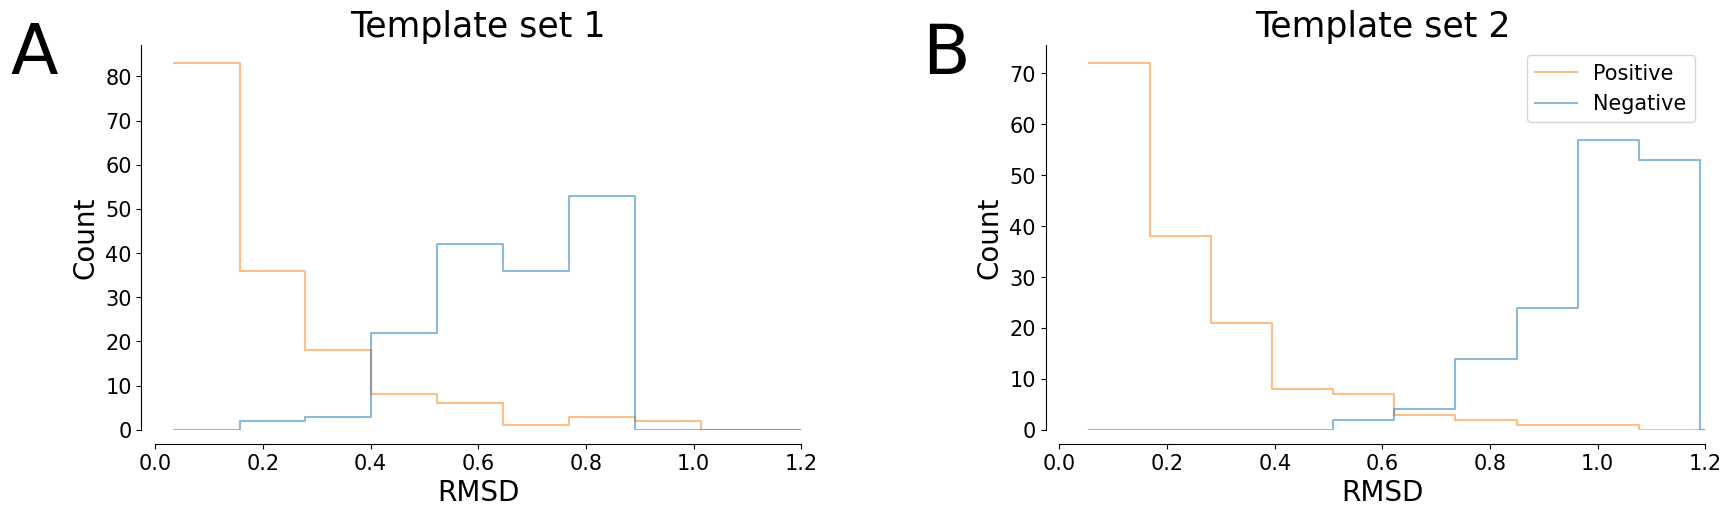

In [64]:
fig, axs = plt.subplots(figsize=[20, 5], nrows=1, ncols=2)

# 1
plot_df = pd.merge(res_df1, identity_df[identity_df["identity"]>0.3].rename(columns={"Query":"match_id", "Target":"template_id"})\
           .assign(allowed=0), on=["match_id", "template_id"], how="left").fillna(1)\
           .query('allowed==1').query('match_id!=template_id')\
           .sort_values("rmsd").drop_duplicates(["target", "match_residues"], keep="first")
# Consider only the hit with lowest rmsd (excluding self cluster matches)
plot_df = plot_df
# Create a balanced set by excluding some negatives
n_tp = len(plot_df[plot_df["true_positive"] == 1])
plot_df = pd.concat([plot_df[plot_df["true_positive"] == 1],
                     plot_df[plot_df["true_positive"] == 0].iloc[:n_tp]])

ax = axs[0]
plot_df = plot_df.sort_values("rmsd").drop_duplicates(["target", "match_residues"], keep="first")
sns.histplot(data = plot_df, x="rmsd", hue="true_positive", alpha=.5, ax=ax, bins=20, 
             fill=False, element="step", legend=False)
ax.set_xlabel("RMSD")
ax.set_xlim([0,1.2])
ax.set_title("Template set 1")

# 2
# res_df3 already has identity and allowed fields
plot_df = pd.merge(res_df2, identity_df[identity_df["identity"]>0.3].rename(columns={"Query":"match_id", "Target":"template_id"})\
           .assign(allowed=0), on=["match_id", "template_id"], how="left").fillna(1)\
           .query('allowed==1').query('match_id!=template_id')\
           .sort_values("rmsd").drop_duplicates(["target", "match_residues"], keep="first")

# Create a balanced set by excluding some negatives
n_tp = len(plot_df[plot_df["true_positive"] == 1])
plot_df = pd.concat([plot_df[plot_df["true_positive"] == 1],
                     plot_df[plot_df["true_positive"] == 0].iloc[:n_tp]])
ax = axs[1]
plot_df = plot_df.sort_values("rmsd").drop_duplicates(["target", "match_residues"], keep="first")
sns.histplot(data = plot_df, x="rmsd", hue="true_positive", alpha=.5, ax=ax, bins=20, 
             fill=False, element="step", legend=True)

ax.legend(labels=["Positive", "Negative"])

ax.set_xlabel("RMSD")
ax.set_xlim([0,1.2])
ax.set_title("Template set 2")

sns.despine(offset=10)
plt.subplots_adjust(hspace=0, wspace=.4)

plt.text(-1.95, 70, "A", fontsize=ANNOT_FONT_SIZE)
plt.text(-.255, 70, "B", fontsize=ANNOT_FONT_SIZE)

plt.savefig(os.path.join(FIGURES, "fs1.png"), dpi=350, bbox_inches="tight", pad_inches=0)

## Figure S3

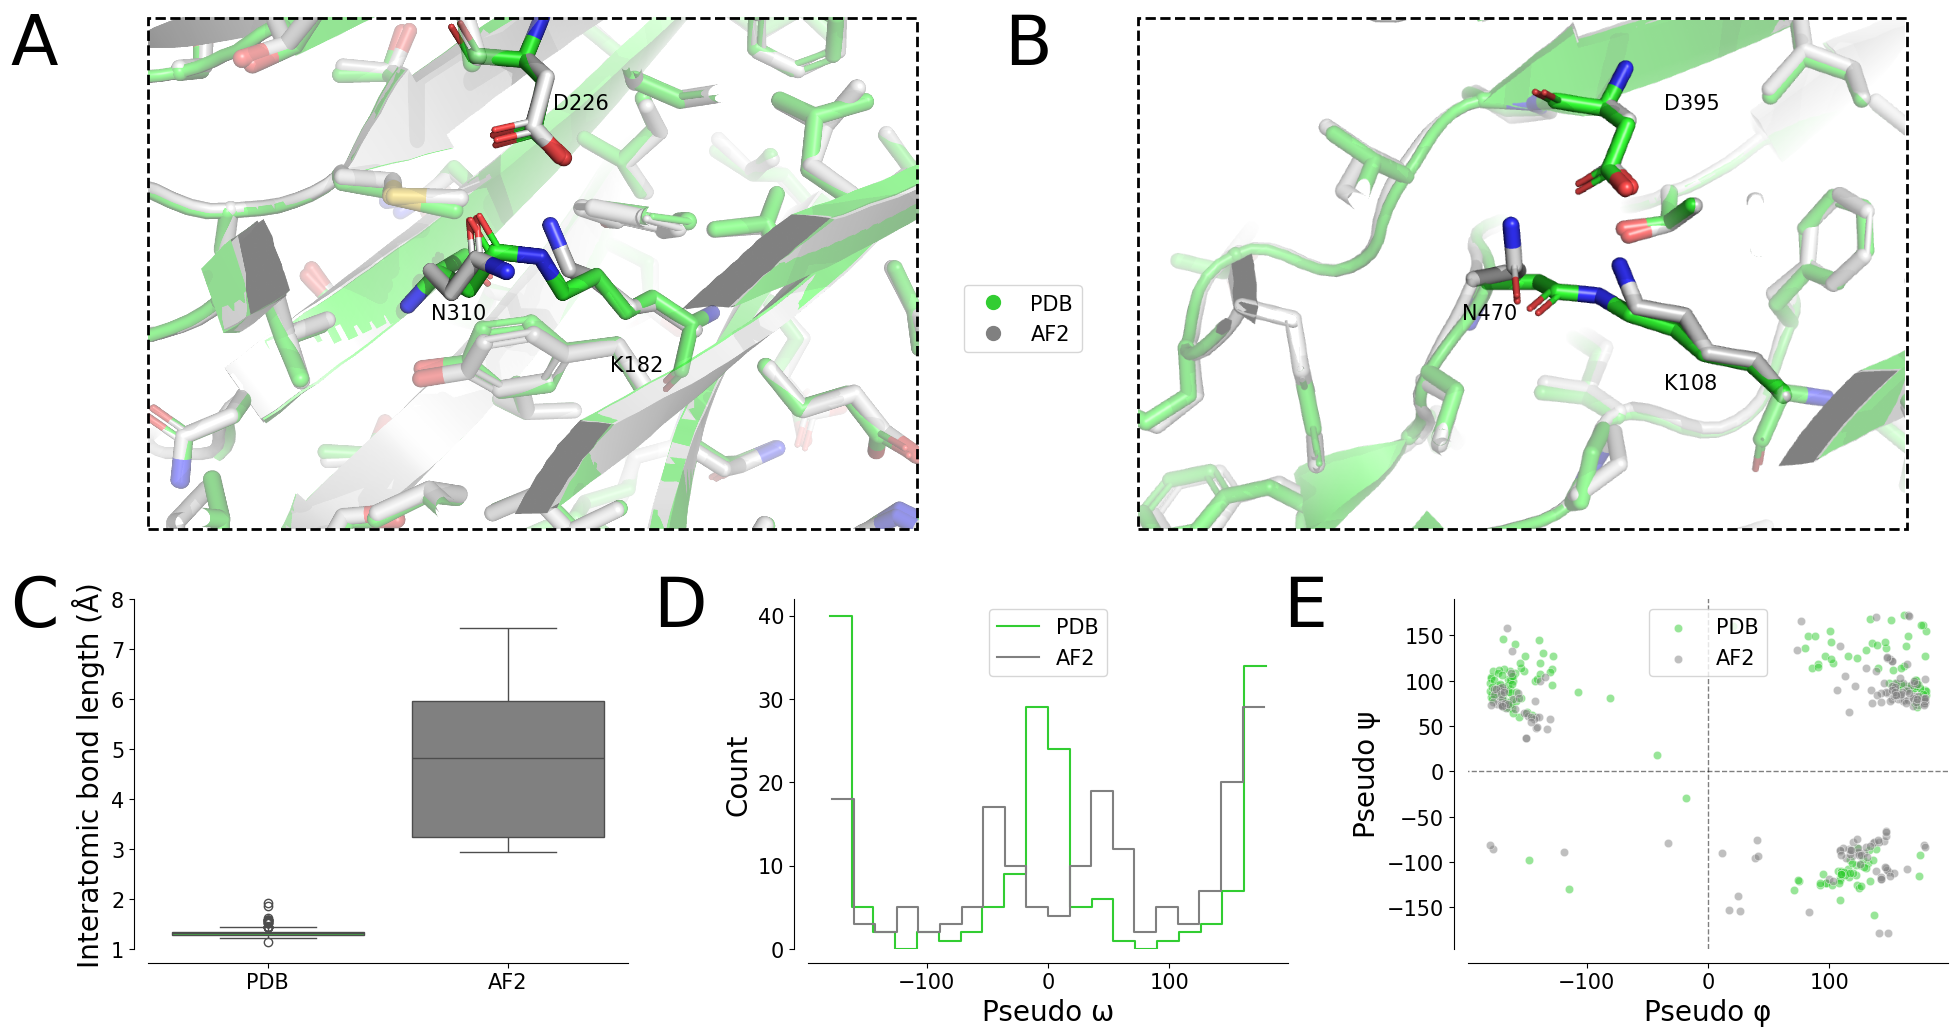

In [35]:
fig = plt.figure(figsize=[20, 10])
gs = gridspec.GridSpec(nrows=2, ncols=6, figure=fig, width_ratios=[1, 1, 1, 1, 1, 1])

# Make plots spanning multiple axes
ax1 = fig.add_subplot(gs[0, :3])
ax2 = fig.add_subplot(gs[0, 3:])
ax3 = fig.add_subplot(gs[1, 0:2])
ax4 = fig.add_subplot(gs[1, 2:4])
ax5 = fig.add_subplot(gs[1, 4:6])

# 1
ax = ax1
ax.axis("off")
# Image of isopep bond
arr_img = plt.imread("data/input_figures/5xcb_182_226_310_af_vs_pdb.png")
cropped_img = arr_img[200:1500, :]
im = OffsetImage(cropped_img, zoom=0.35)
ab = AnnotationBbox(im, xy=(0, 0), xybox=(0, 0), box_alignment=(0, 0), bboxprops=dict(color="white"))
ax.add_artist(ab)

# Box around
box = mpl.patches.Rectangle(
    (0.5 - 1 / 2, 0.5 - 1 / 2),  # Lower-left corner
    .95,
    1.46,
    edgecolor="black",
    linewidth=2,
    linestyle="--",
    facecolor="none", 
    zorder=100,
    clip_on=False
)
ax.add_patch(box)

ax.text(x=.57, y=.45, s="K182")
ax.text(x=.35, y=.6, s="N310")
ax.text(x=.5, y=1.2, s="D226")

# Legend
legend_elements = [
    Line2D([0], [0], marker="o", color="limegreen", lw=0, ms=10, label="PDB"),
    Line2D([0], [0], marker="o", color="gray", lw=0, ms=10, label="AF2"),
]

legend = ax.legend(
    handles=legend_elements,
    loc="center",
    bbox_to_anchor=(1.08, 0.6),
    frameon=True,
)

# 2
ax = ax2
ax.axis("off")
# Image of isopep bond
arr_img = plt.imread("data/input_figures/6m3y_108_395_470_af_vs_pdb.png")
cropped_img = arr_img[150:760, 300:1220]
im = OffsetImage(cropped_img, zoom=0.6)
ab = AnnotationBbox(im, xy=(0, 0), xybox=(0, 0), box_alignment=(0, 0), bboxprops=dict(color="white"))
ax.add_artist(ab)

# Add box around
box = mpl.patches.Rectangle(
    (0.5 - 1 / 2, 0.5 - 1 / 2),  # Lower-left corner
    .95,
    1.46,
    edgecolor="black",
    linewidth=2,
    linestyle="--",
    facecolor="none", 
    zorder=100,
    clip_on=False
)
ax.add_patch(box)

ax.text(x=.65, y=.4, s="K108")
ax.text(x=.4, y=.6, s="N470")
ax.text(x=.65, y=1.2, s="D395")

# 3
ax = ax3
sns.boxplot(x=1, y=dt_df["bond_length"].to_list(), ax=ax, color="limegreen")
sns.boxplot(x=0, y=af_df["bond_length"].to_list(), ax=ax, color="gray")
ax.set_xticks([0,1], ["PDB", "AF2"])
ax.set_ylabel("Interatomic bond length (Å)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim([1,8])
sns.despine(offset=10, ax=ax)

# 4
ax = ax4
sns.histplot(dt_df["pseudo_omega"].to_list(), ax=ax, fill=False, element="step", bins=20, label="PDB", color="limegreen")
sns.histplot(af_df["pseudo_omega"].to_list(), ax=ax,fill=False, element="step", bins=20, label="AF2", color="gray")
ax.legend(loc="upper center")
ax.set_xlabel("Pseudo ω")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
sns.despine(offset=10, ax=ax)

# 5
ax = ax5
sns.scatterplot(dt_df, x="pseudo_phi", y="pseudo_psi", ax=ax, label="PDB", color="limegreen", alpha=.5)
sns.scatterplot(af_df, x="pseudo_phi", y="pseudo_psi", ax=ax, label="AF2", color="gray", alpha=.5)

ax.axvline(0, -181, 181, linewidth=1, color="black", ls="--", alpha=.5)
ax.axhline(0, -181, 181, linewidth=1, color="black", ls="--", alpha=.5)

ax.legend(loc="upper center")
ax.set_xlabel("Pseudo φ")
ax.set_ylabel("Pseudo ψ")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
sns.despine(offset=10, ax=ax)


plt.subplots_adjust(hspace=.2, wspace=1.2, left=0, right=.9)
plt.text(-1400,780, "A", fontsize=ANNOT_FONT_SIZE)
plt.text(-580,780, "B", fontsize=ANNOT_FONT_SIZE)
plt.text(-1400,160, "C", fontsize=ANNOT_FONT_SIZE)
plt.text(-870,160, "D", fontsize=ANNOT_FONT_SIZE)
plt.text(-350,160, "E", fontsize=ANNOT_FONT_SIZE)

plt.savefig(os.path.join(FIGURES, "sf3.png"), dpi=350, bbox_inches="tight")

plt.show()

Text(0.65, 1.2, 'D395')

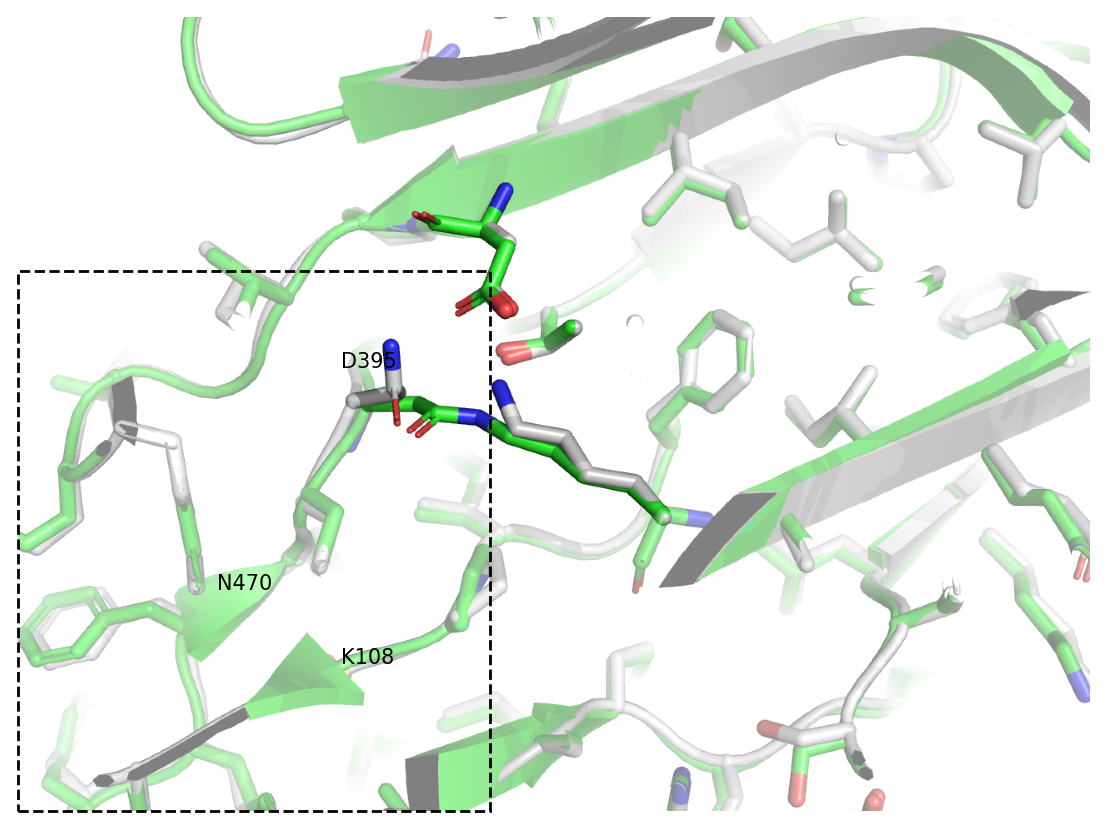

In [15]:
fig, ax = plt.subplots()
ax.axis("off")
# Image of isopep bond
arr_img = plt.imread("data/input_figures/6m3y_108_395_470_af_vs_pdb.png")
cropped_img = arr_img[:1200, 300:]
im = OffsetImage(cropped_img, zoom=0.6)
ab = AnnotationBbox(im, xy=(0, 0), xybox=(0, 0), box_alignment=(0, 0), bboxprops=dict(color="white"))
ax.add_artist(ab)

# Add box around
box = mpl.patches.Rectangle(
    (0.5 - 1 / 2, 0.5 - 1 / 2),  # Lower-left corner
    .95,
    1.46,
    edgecolor="black",
    linewidth=2,
    linestyle="--",
    facecolor="none", 
    zorder=100,
    clip_on=False
)
ax.add_patch(box)

ax.text(x=.65, y=.4, s="K108")
ax.text(x=.4, y=.6, s="N470")
ax.text(x=.65, y=1.2, s="D395")

## Figure S4

In [36]:
import sys
sys.path.append("bin")
from pfamenv import PFAM_USER, PFAM_HOST, PFAM_PASSWORD, PFAM_PORT
from mysql import connector
from matplotlib_venn import venn2

def domain(pfamA_accs:list) -> pd.DataFrame:
    """
        Maps pfamA_acc to pfamA_id
    
    
    """
    cnx = connector.connect(user=PFAM_USER,
                            password=PFAM_PASSWORD,
                            port=PFAM_PORT,
                            host=PFAM_HOST)
    cursor = cnx.cursor()
    pfamA_accs = ",".join([f"'{u}'" for u in pfamA_accs])
    # For this use the most recent pfam
    cursor.execute(f"SELECT pfamA_acc, pfamA_id FROM pfam_37_0.pfamA\
                WHERE pfamA_acc IN ({pfamA_accs})")

    output = cursor.fetchall()

    return(pd.DataFrame(output, columns=["pfamA_acc", "pfamA_id"]))
# All domains from IB-containing proteins, excluding IB-containing domains
ib_proteins = str_df[(str_df["prob"]>.5)&(~str_df["taxonomy"].isna())]["target"].unique()
ib_domains = str_df[(str_df["prob"]>.5)&(~str_df["taxonomy"].isna())]["pfamA_acc"].unique()
d_df_domains = strd_df[(strd_df["pfamseq_acc"].isin(ib_proteins))&(~strd_df["pfamA_acc"].isin(ib_domains))]["pfamA_acc"].unique()
count_df = strd_df[(strd_df["pfamseq_acc"].isin(ib_proteins))&(~strd_df["pfamA_acc"].isin(ib_domains))].value_counts("pfamA_acc").reset_index()
count_df = pd.merge(count_df, domain(count_df["pfamA_acc"].unique()))

# Data for venn diagram
str_uniprot = str_df[(~str_df["taxonomy"].isna())&(str_df["prob"]>.5)]["target"].unique()
hmm_uniprot = hmm_df[(hmm_df["taxonomy"]!="ND")]["uniprot_acc"].unique()
common = [u for u in str_uniprot if u in hmm_uniprot]

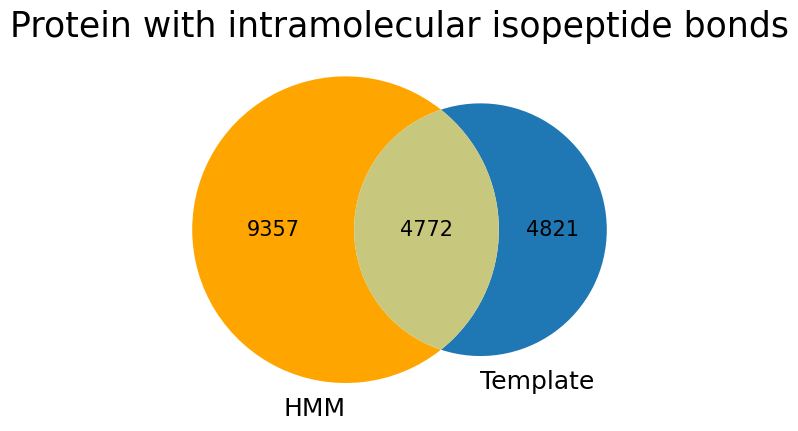

In [37]:
fig, ax = plt.subplots()

cmap = mpl.colormaps['Paired']
venn2(subsets=(len(hmm_uniprot)-len(common),len(str_uniprot)-len(common), len(common)), set_labels=["HMM", "Template"], 
      set_colors=["orange", "C0"], ax=ax, alpha=1)
ax.set_title("Protein with intramolecular isopeptide bonds")

plt.savefig(os.path.join(FIGURES, "sf4.png"), dpi=350, bbox_inches="tight", pad_inches=0)

## Figure S5

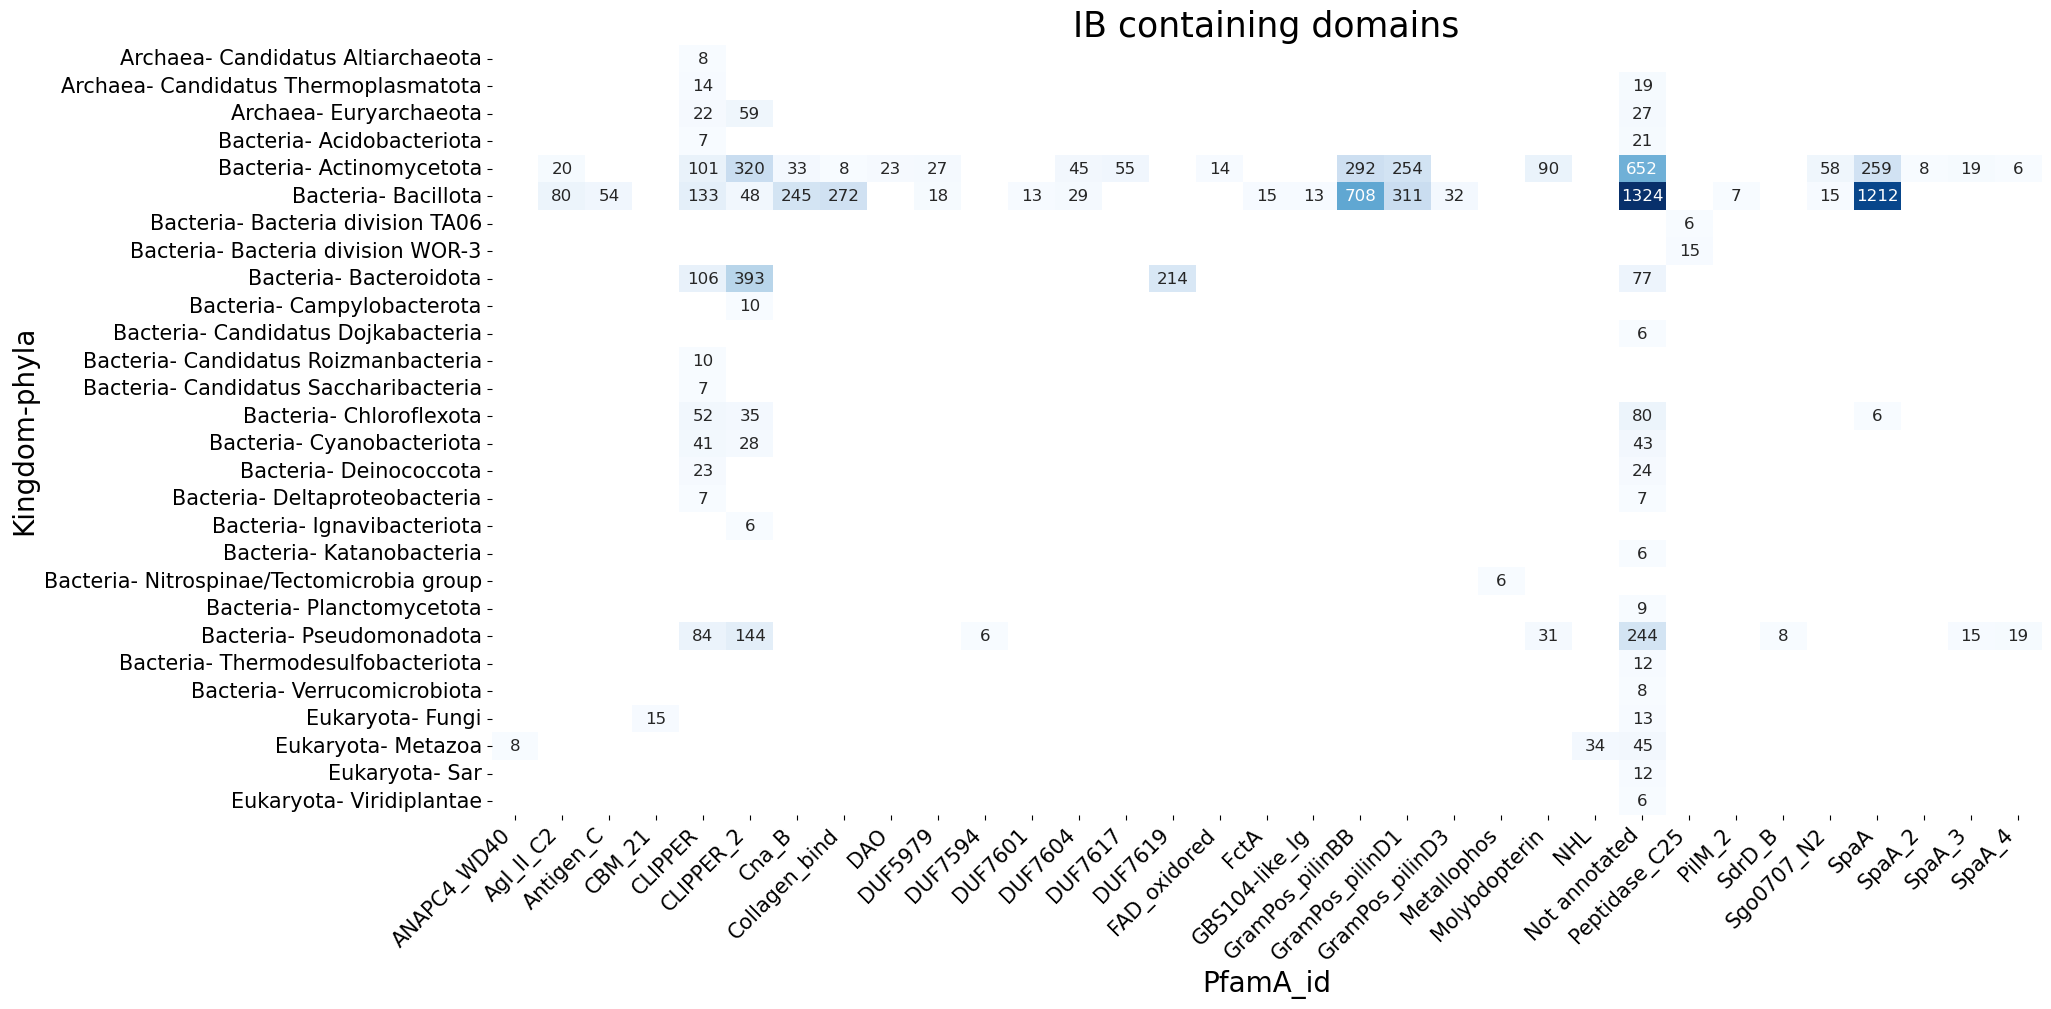

In [382]:
fig, ax = plt.subplots(figsize=[20, 10])

plot_df = str_df[(str_df["prob"]>.5)&(~str_df["taxonomy"].isna())].drop_duplicates("target").copy()
plot_df["phyla"] = plot_df["taxonomy"].apply(lambda x: x.split(";")[1].replace(".", "") if len(x.split(";")) >= 2 else np.NaN)
plot_df["pfamA_id"] = plot_df["pfamA_id"].replace({"DUF11":"CLIPPER", "DUF7507":"CLIPPER_2"}).fillna("Not annotated")
plot_df = plot_df.value_counts(["kingdom", "phyla", "pfamA_id"]).reset_index()\
                 .query('count>5&kingdom!="unclassified sequences"')\
                 .pivot(index=["kingdom", "phyla"], columns="pfamA_id", values="count").fillna(0).astype(int)

g=sns.heatmap(plot_df, cmap="Blues", ax=ax, mask=(plot_df==0), 
              annot=True, annot_kws={'fontsize':12}, fmt=".0f", cbar=False)

g.set_yticklabels(g.get_yticklabels(), rotation=0)
g.set_xticklabels(g.get_xticklabels(), rotation=45, ha='right')
ax.set_title("IB containing domains")
ax.set_ylabel("Kingdom-phyla")
ax.set_xlabel("PfamA_id")

plt.savefig(os.path.join(FIGURES, "sf5.png"), dpi=350, bbox_inches="tight", pad_inches=0)

## Figure S6

[[<matplotlib.axis.XTick at 0x7ff3e2229a60>,

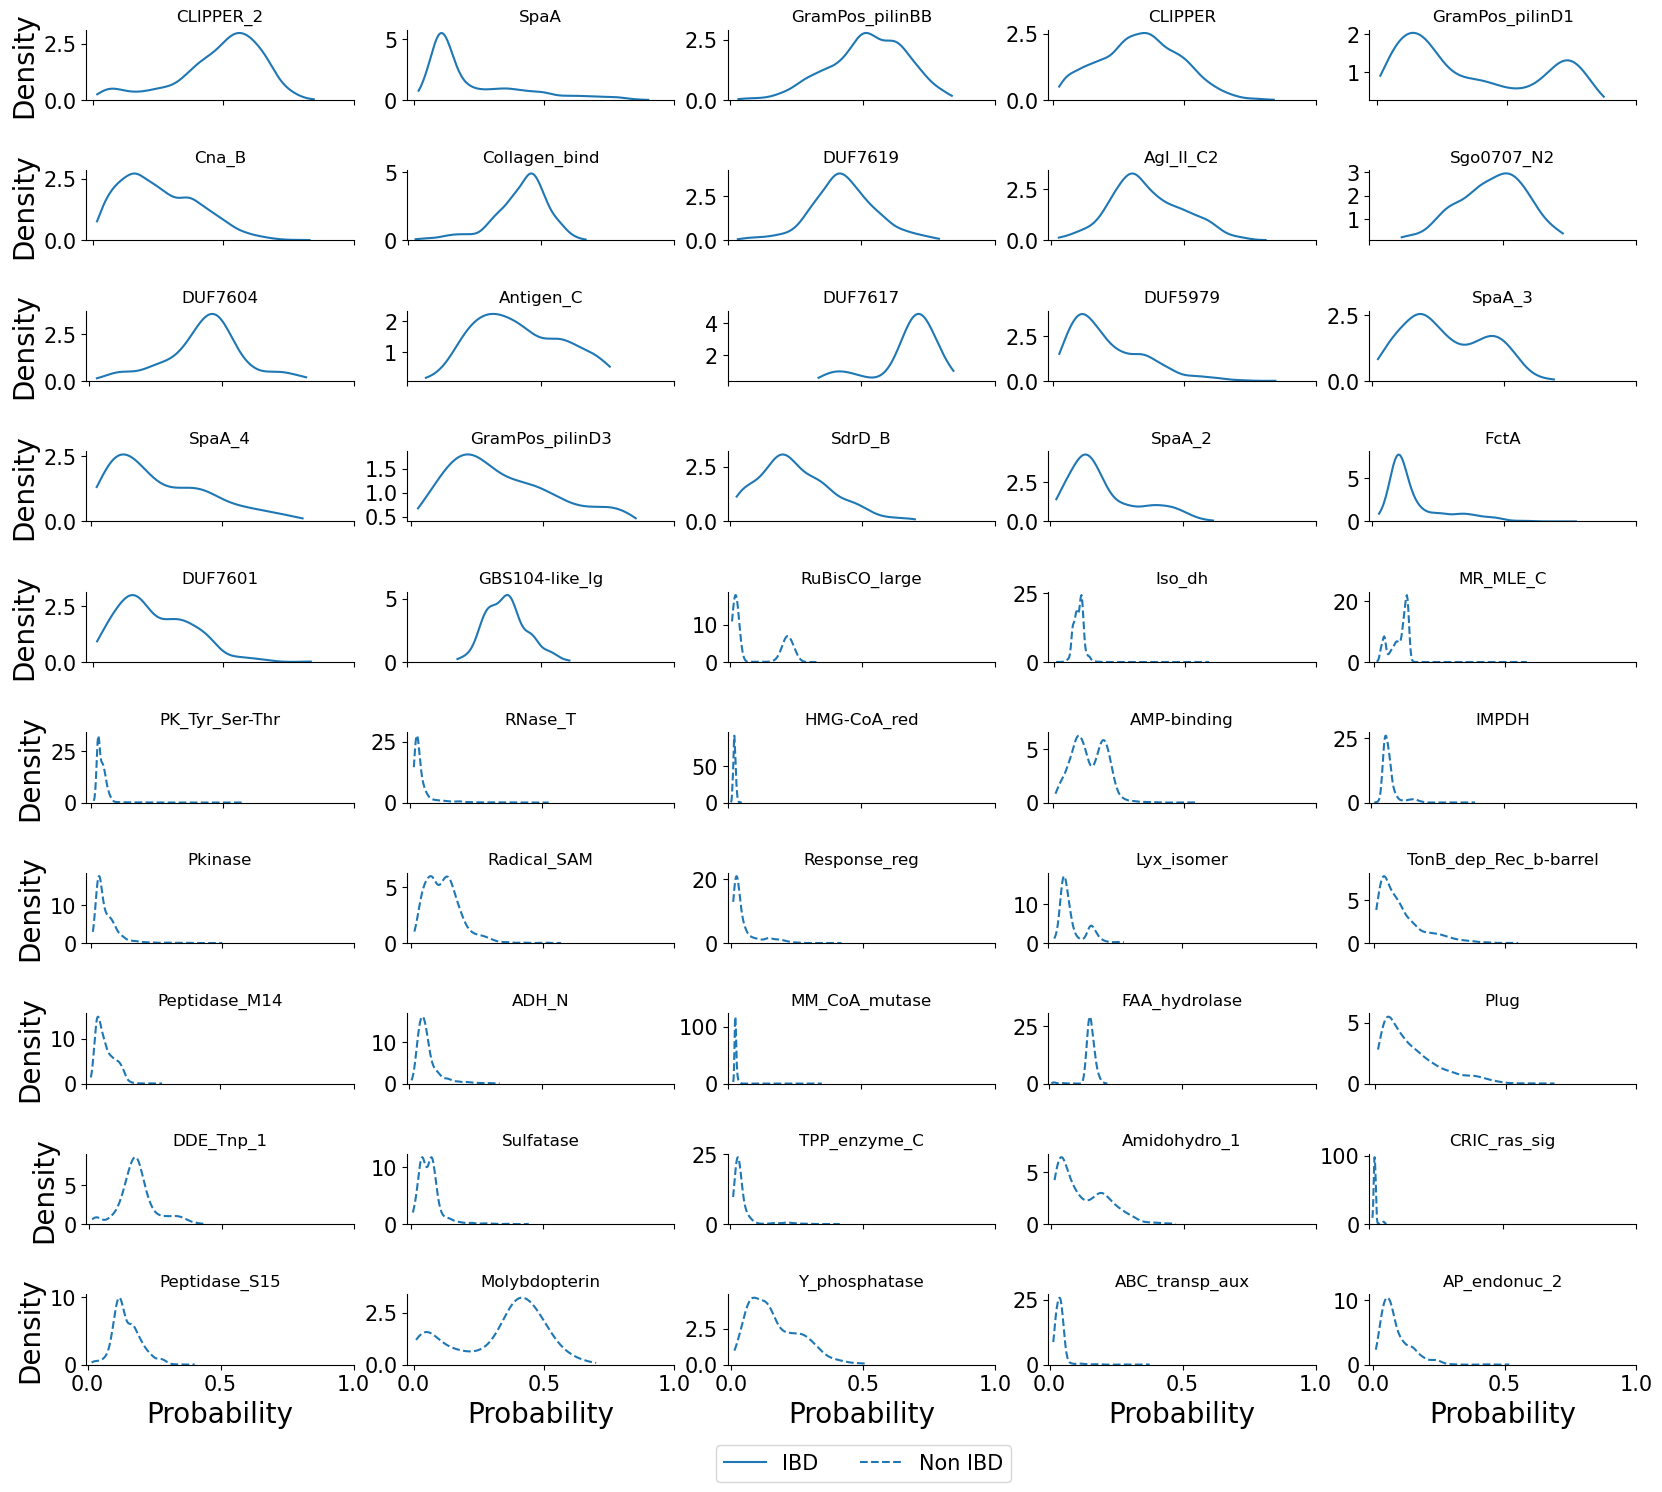

In [11]:
# Keep only the match with lower rmsd per domain

nrows=10
ncols=5

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=[20,15])
plt.subplots_adjust(left=None, bottom=None, right=None, top=1, wspace=None, hspace=1)

axes = [[row, col] for row in range(nrows) for col in range(ncols)]
for indx, pfamA_id in zip(axes, isopep + str_df[~str_df["pfamA_id"]\
                          .isin(isopep)].value_counts("pfamA_id").reset_index()["pfamA_id"][:50-len(isopep)].to_list()):
    ax = axs[indx[0], indx[1]]
    if pfamA_id not in isopep:
        sns.kdeplot(str_df[str_df["pfamA_id"]==pfamA_id].sort_values("rmsd").drop_duplicates(["target", "match_residues"]),
                    x="prob", cut=0, ax=ax, ls="--")
    else:
        sns.kdeplot(str_df[str_df["pfamA_id"]==pfamA_id].sort_values("rmsd").drop_duplicates(["target", "match_residues"]),
                    x="prob", cut=0, ax=ax)
    if pfamA_id == "DUF11":
        pfamA_id = "CLIPPER"
    if pfamA_id == "DUF7507":
        pfamA_id = "CLIPPER_2"
    ax.set_title(pfamA_id, fontsize=12)
    ax.set_xlabel("Probability")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if indx[0] == nrows-1:
        ax.set_xticks([0,.5,1])
        ax.set_xlabel("Probability")
    else:
       ax.set(xticks=[0,.5,1], xlabel="")
       plt.setp(ax.get_xticklabels(), visible=False)

    if indx[1] == 0:
        ax.set_ylabel("Density")
    else:
        ax.set_ylabel("")
    

ibd_line, = plt.plot([], [], linestyle='-', color='C0', label='IBD')
non_ibd_line, = plt.plot([], [], linestyle='--', color='C0', label='Non IBD')
plt.legend(handles=[ibd_line, non_ibd_line], ncol=2, bbox_to_anchor=(-1.3,-1))

# IDK why but this is needed
ax.set(xticks=[0,.5,1])

plt.savefig(os.path.join(FIGURES, "sf6.png"), dpi=350, bbox_inches="tight", pad_inches=0)

In [15]:
str_df[str_df["pfamA_id"]=="SpaA_3"].sort_values("rmsd")

target template match_residues template_residues pfamA_acc  \
2706    A0A7X1PE05   2x9x_A    270_320_363       349_405_428   PF20674   
3829    A0A661EYF6   2x9x_A    457_503_549       349_405_428   PF20674   
5306    A0A261GAS3   2xid_A    333_390_449       610_680_715   PF20674   
6447    A0A0U1Q3Q7   7w7i_A    116_173_227        139_213_52   PF20674   
7209    A0A0A1CU64   7vcr_A    283_344_399       717_791_820   PF20674   
...            ...      ...            ...               ...       ...   
312287  A0A373DCQ5   7w7i_A    541_597_647        139_213_52   PF20674   
319327  A0A852WPJ5   2x9z_A    583_647_702       349_405_428   PF20674   
315614  A0A2S3ZY56   3gld_A    393_451_504       179_258_303   PF20674   
334764  A0A505H1R9   2x9x_A    391_451_501       349_405_428   PF20674   
355968  A0A1S9MB96   3gld_A    409_473_526       179_258_303   PF20674   

        seq_start  seq_end                                           taxonomy  \
2706        278.0    365.0          Bacteria; Chloroflexota; Dehalococcoidia.   
3829        467.0    551.0     Bacteria; Pseudomonadota; Gammaproteobacteria.   
5306        328.0    451.0  Bacteria; Actinomycetota; Actinomycetes; Bifid...   
6447        111.0    229.0  Bacteria; Pseudomonadota; Betaproteobacteria; ...   
7209        278.0    401.0  Bacteria; Actinomycetota; Actinomycetes; Micro...   
...           ...      ...                                                ...   
312287      536.0    649.0  Bacteria; Actinomycetota; Actinomycetes; Micro...   
319327      578.0    704.0  Bacteria; Actinomycetota; Actinomycetes; Micro...   
315614      388.0    506.0  Bacteria; Actinomycetota; Actinomycetes; Micro...   
334764      386.0    503.0  Bacteria; Actinomycetota; Actinomycetes; Micro...   
355968      404.0    528.0  Bacteria; Actinomycetota; Actinomycetes; Micro...   

                              species   kingdom pfamA_id        clan_id  \
2706        Dehalococcoidia bacterium  Bacteria   SpaA_3  Transthyretin   
3829    Gammaproteobacteria bacterium  Bacteria   SpaA_3  Transthyretin   
5306       Bifidobacterium aquikefiri  Bacteria   SpaA_3  Transthyretin   
6447            Lampropedia cohaerens  Bacteria   SpaA_3  Transthyretin   
7209      Arthrobacter sp. PAMC 25486  Bacteria   SpaA_3  Transthyretin   
...                               ...       ...      ...            ...   
312287           Leucobacter sp. wl10  Bacteria   SpaA_3  Transthyretin   
319327        Pedococcus badiiscoriae  Bacteria   SpaA_3  Transthyretin   
315614         Arthrobacter glacialis  Bacteria   SpaA_3  Transthyretin   
334764      Brevibacterium sp. XM4083  Bacteria   SpaA_3  Transthyretin   
355968  Arthrobacter sp. SRS-W-1-2016  Bacteria   SpaA_3  Transthyretin   

                        plddt  plddt90   rmsd      prob      rASA  is_domain  
2706    [93.38, 93.06, 90.75]     True  0.449  0.688498  0.006322       True  
3829      [96.5, 96.0, 95.25]     True  0.469  0.655790  0.002517       True  
5306    [98.12, 97.88, 97.69]     True  0.489  0.620707  0.000000       True  
6447    [97.88, 98.06, 97.44]     True  0.495  0.598462  0.016774       True  
7209    [97.31, 97.44, 97.31]     True  0.497  0.585073  0.031248       True  
...                       ...      ...    ...       ...       ...        ...  
312287   [97.88, 98.31, 98.0]     True  0.973  0.033306  0.005495       True  
319327  [97.56, 97.19, 97.38]     True  0.973  0.031469  0.026967       True  
315614  [97.25, 97.19, 97.31]     True  0.975  0.032420  0.009886       True  
334764  [97.44, 97.31, 94.88]     True  0.992  0.028121  0.014136       True  
355968  [96.69, 96.81, 95.44]     True  0.996  0.024216  0.058706       True  

[407 rows x 18 columns]

## Old

### Mix

NameError: name 'venn2' is not defined

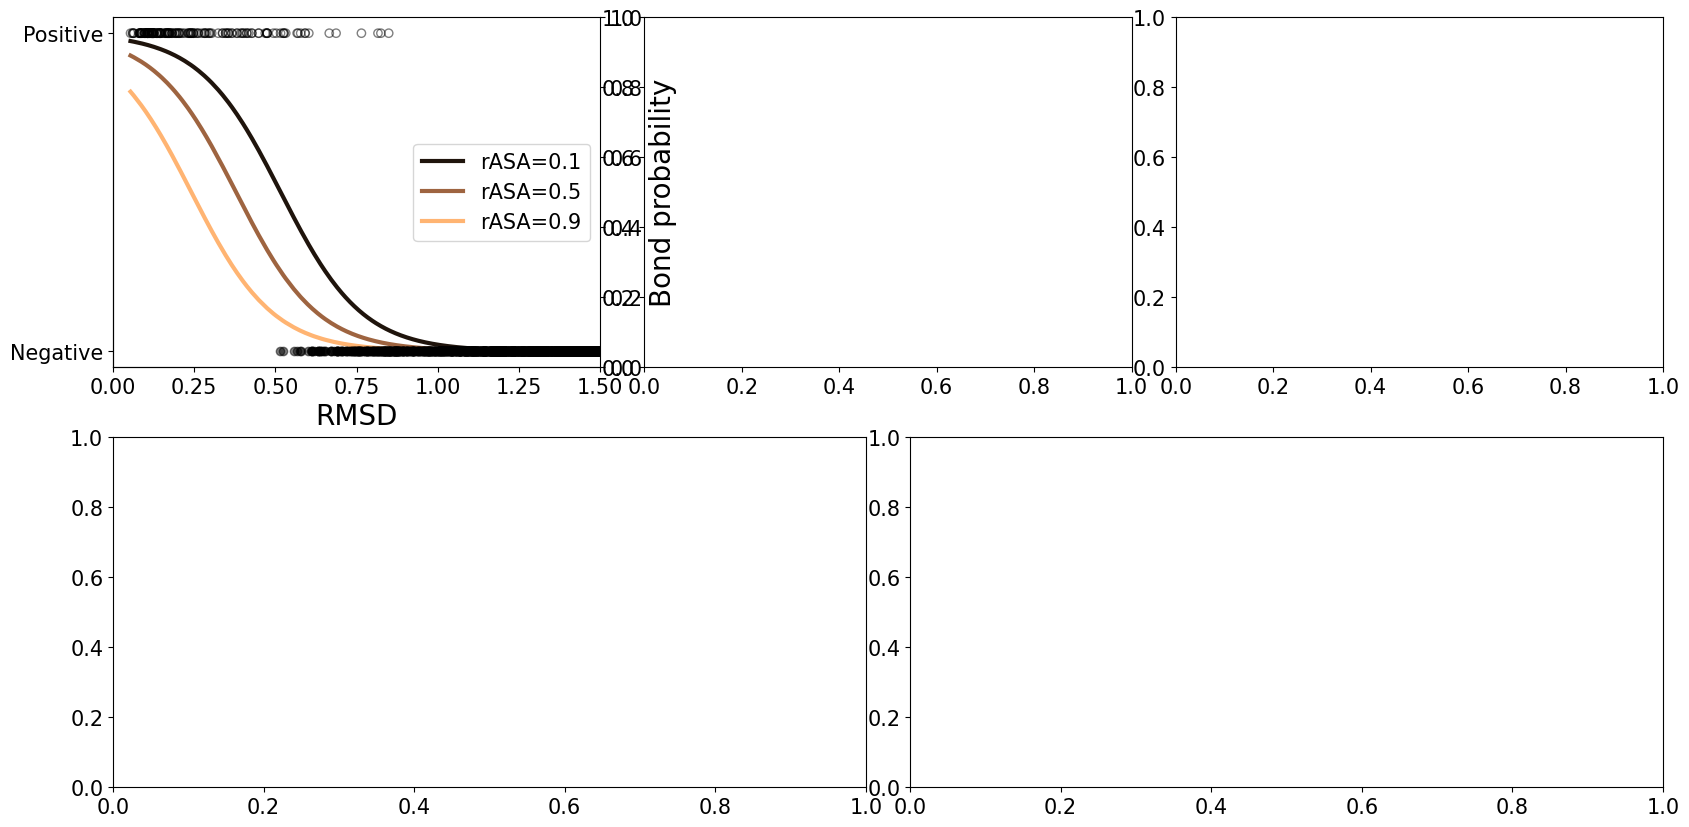

In [14]:
fig = plt.figure(figsize=[20, 10])
gs = gridspec.GridSpec(nrows=2, ncols=6, figure=fig, width_ratios=[1, 1, 1, 1, 1, 1])

ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[0, 2:4])
ax3 = fig.add_subplot(gs[0, 4:6])
ax4 = fig.add_subplot(gs[1, 0:3])
ax5 = fig.add_subplot(gs[1, 3:6])

# 1
ax = ax1
plot_df = res_df[~res_df["mean_rASA"].isna()].sort_values("rmsd").drop_duplicates(["match_id"], keep="first")
# This is a false neg:
plot_df = plot_df[plot_df["match_id"]!="2X9Y_193_241_318"]

sns.scatterplot(plot_df[plot_df["true_positive"]==1], x="rmsd", y="true_positive", alpha=.5, lw=1, ax=ax, edgecolors="black", 
               facecolors='none')
sns.scatterplot(plot_df[plot_df["true_positive"]==0], x="rmsd", y="true_positive", alpha=.5, lw=1, ax=ax, edgecolors="black", 
               facecolors='black')

copper = plt.get_cmap('copper')
for mean_asa in [0.1, 0.5, 0.9]:
    X =  plot_df.sort_values(["rmsd", "mean_rASA"])[["rmsd", "mean_rASA"]].assign(mean_rASA=mean_asa).to_numpy()
    ax.plot(X[:,0], CLF.predict_proba(X)[:,1], alpha=1, lw=3, ls="-", color=copper(mean_asa), zorder=0,
            label = f"rASA={mean_asa}")
ax.legend(loc="center right")
ax.set_yticks([0, 1])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.legend(title='Class', labels=['Positive', 'Negative'])
ax.set_ylabel("")
ax.set_xlabel("RMSD")
ax.set_yticks([0,1], ["Negative", "Positive"])
ax.set_xlim([0,1.5])

ax_r = ax.twinx()
ax_r.set_ylabel('Bond probability', color="black")
ax_r.tick_params(axis='y', labelcolor="black")

# 2
ax=ax2
cmap = mpl.colormaps['Paired']
venn2(subsets=(len(hmm_uniprot)-len(common),len(str_uniprot)-len(common), len(common)), set_labels=["HMM", "Template"], 
      set_colors=["orange", "C0"], ax=ax, alpha=1)
ax.set_title("Protein with IBs")

# 3
ax = ax3
ax.axis("off")
plot_df = str_df[(str_df["kingdom"].isin(["Bacteria", "Archaea", "Eukaryota"]))\
          &(str_df["prob"]>0.5)]
plot_df = pd.DataFrame(plot_df.value_counts("kingdom")).reset_index()
plot_df["kingdom"] = plot_df["kingdom"] + " (" + plot_df["count"].astype(str) + ")"
count_dict = dict(zip(plot_df["kingdom"], plot_df["count"]))

labels = count_dict.keys()
sizes = list(count_dict.values())

cmap = mpl.colormaps['Blues']
ax.pie(sizes, labels=labels, colors=["C0", cmap(0.5), cmap(1)])
ax.set_title("Taxonomy distribution")

# 4
ax = ax4
plot_df = pd.concat([pd.DataFrame(str_df[(str_df["prob"]>.5)&(~str_df["taxonomy"].isna())].fillna("ND").value_counts(["pfamA_id"])).reset_index()\
                    .query('count>10').assign(Method="Template"),
                    pd.DataFrame(hmm_df[hmm_df["taxonomy"]!="ND"].fillna("ND").value_counts(["pfamA_id"])).reset_index().query('count>10')\
                    .assign(Method="HMM")
                   ]).query('(pfamA_id!="ND")')
plot_df["Pfam domain id"] = plot_df["pfamA_id"].replace({"DUF11":"CLIPPER", "DUF7507":"CLIPPER_2"})
plot_df["Log count"] = plot_df["count"].apply(np.log10)

common_domains = plot_df.value_counts("Pfam domain id").reset_index().query('count==2')["Pfam domain id"].to_list()
plot_df["Detected by"] = "sequence only"
plot_df.loc[(plot_df["Pfam domain id"].isin(common_domains)), "Detected by"] = "both methods"
struct_domains = plot_df[plot_df["Method"]=="Template"]["Pfam domain id"]
plot_df.loc[~(plot_df["Pfam domain id"].isin(common_domains))&\
            (plot_df["Pfam domain id"].isin(struct_domains)), "Detected by"] = "structure only"

order = plot_df.groupby("Pfam domain id").sum("count").reset_index().sort_values("count")["Pfam domain id"]
hue_order = ["HMM", "Template"]

order = plot_df.groupby("Pfam domain id").sum("count").reset_index().sort_values("count")["Pfam domain id"]
hue_order = ["HMM", "Template"]
g=sns.barplot(data=plot_df, x="Pfam domain id", y="Log count",
            palette=["orange", "C0"], hue="Method",
            order=order, dodge=True,
            hue_order=hue_order, ax=ax, legend=True)
ax.tick_params(axis='x', rotation=90)
sns.despine(ax=ax, offset=10)
ax.set_ylabel("Log count")
ax.set_xlabel("")
ax.set_title("IB containing domains")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# 5
ax=ax5
count_df = strd_df[(strd_df["pfamseq_acc"].isin(ib_proteins))&(~strd_df["pfamA_acc"].isin(ib_domains))].value_counts("pfamA_acc").reset_index()
count_df = pd.merge(count_df, domain(count_df["pfamA_acc"].unique()))
g=sns.barplot(count_df.iloc[:30].sort_values("count"), y="count", x="pfamA_id", color="C0", ax=ax)
g.tick_params(axis='x', rotation=90)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
sns.despine(ax=ax, offset=10)
ax.set_xlabel("")
ax.set_title("IB co-localising domains")

plt.subplots_adjust(hspace=.5, wspace=1.2, left=0, right=.9)
plt.text(-.45,.85, "A", fontsize=ANNOT_FONT_SIZE)
plt.text(1.85,.85, "B", fontsize=ANNOT_FONT_SIZE)
plt.text(3.5,.85, "C", fontsize=ANNOT_FONT_SIZE)
plt.text(-.45,-.6, "C", fontsize=ANNOT_FONT_SIZE)
plt.text(2.55,-.6, "D", fontsize=ANNOT_FONT_SIZE)

#plt.savefig(os.path.join(FIGURES, "f4.png"), dpi=350, bbox_inches="tight")

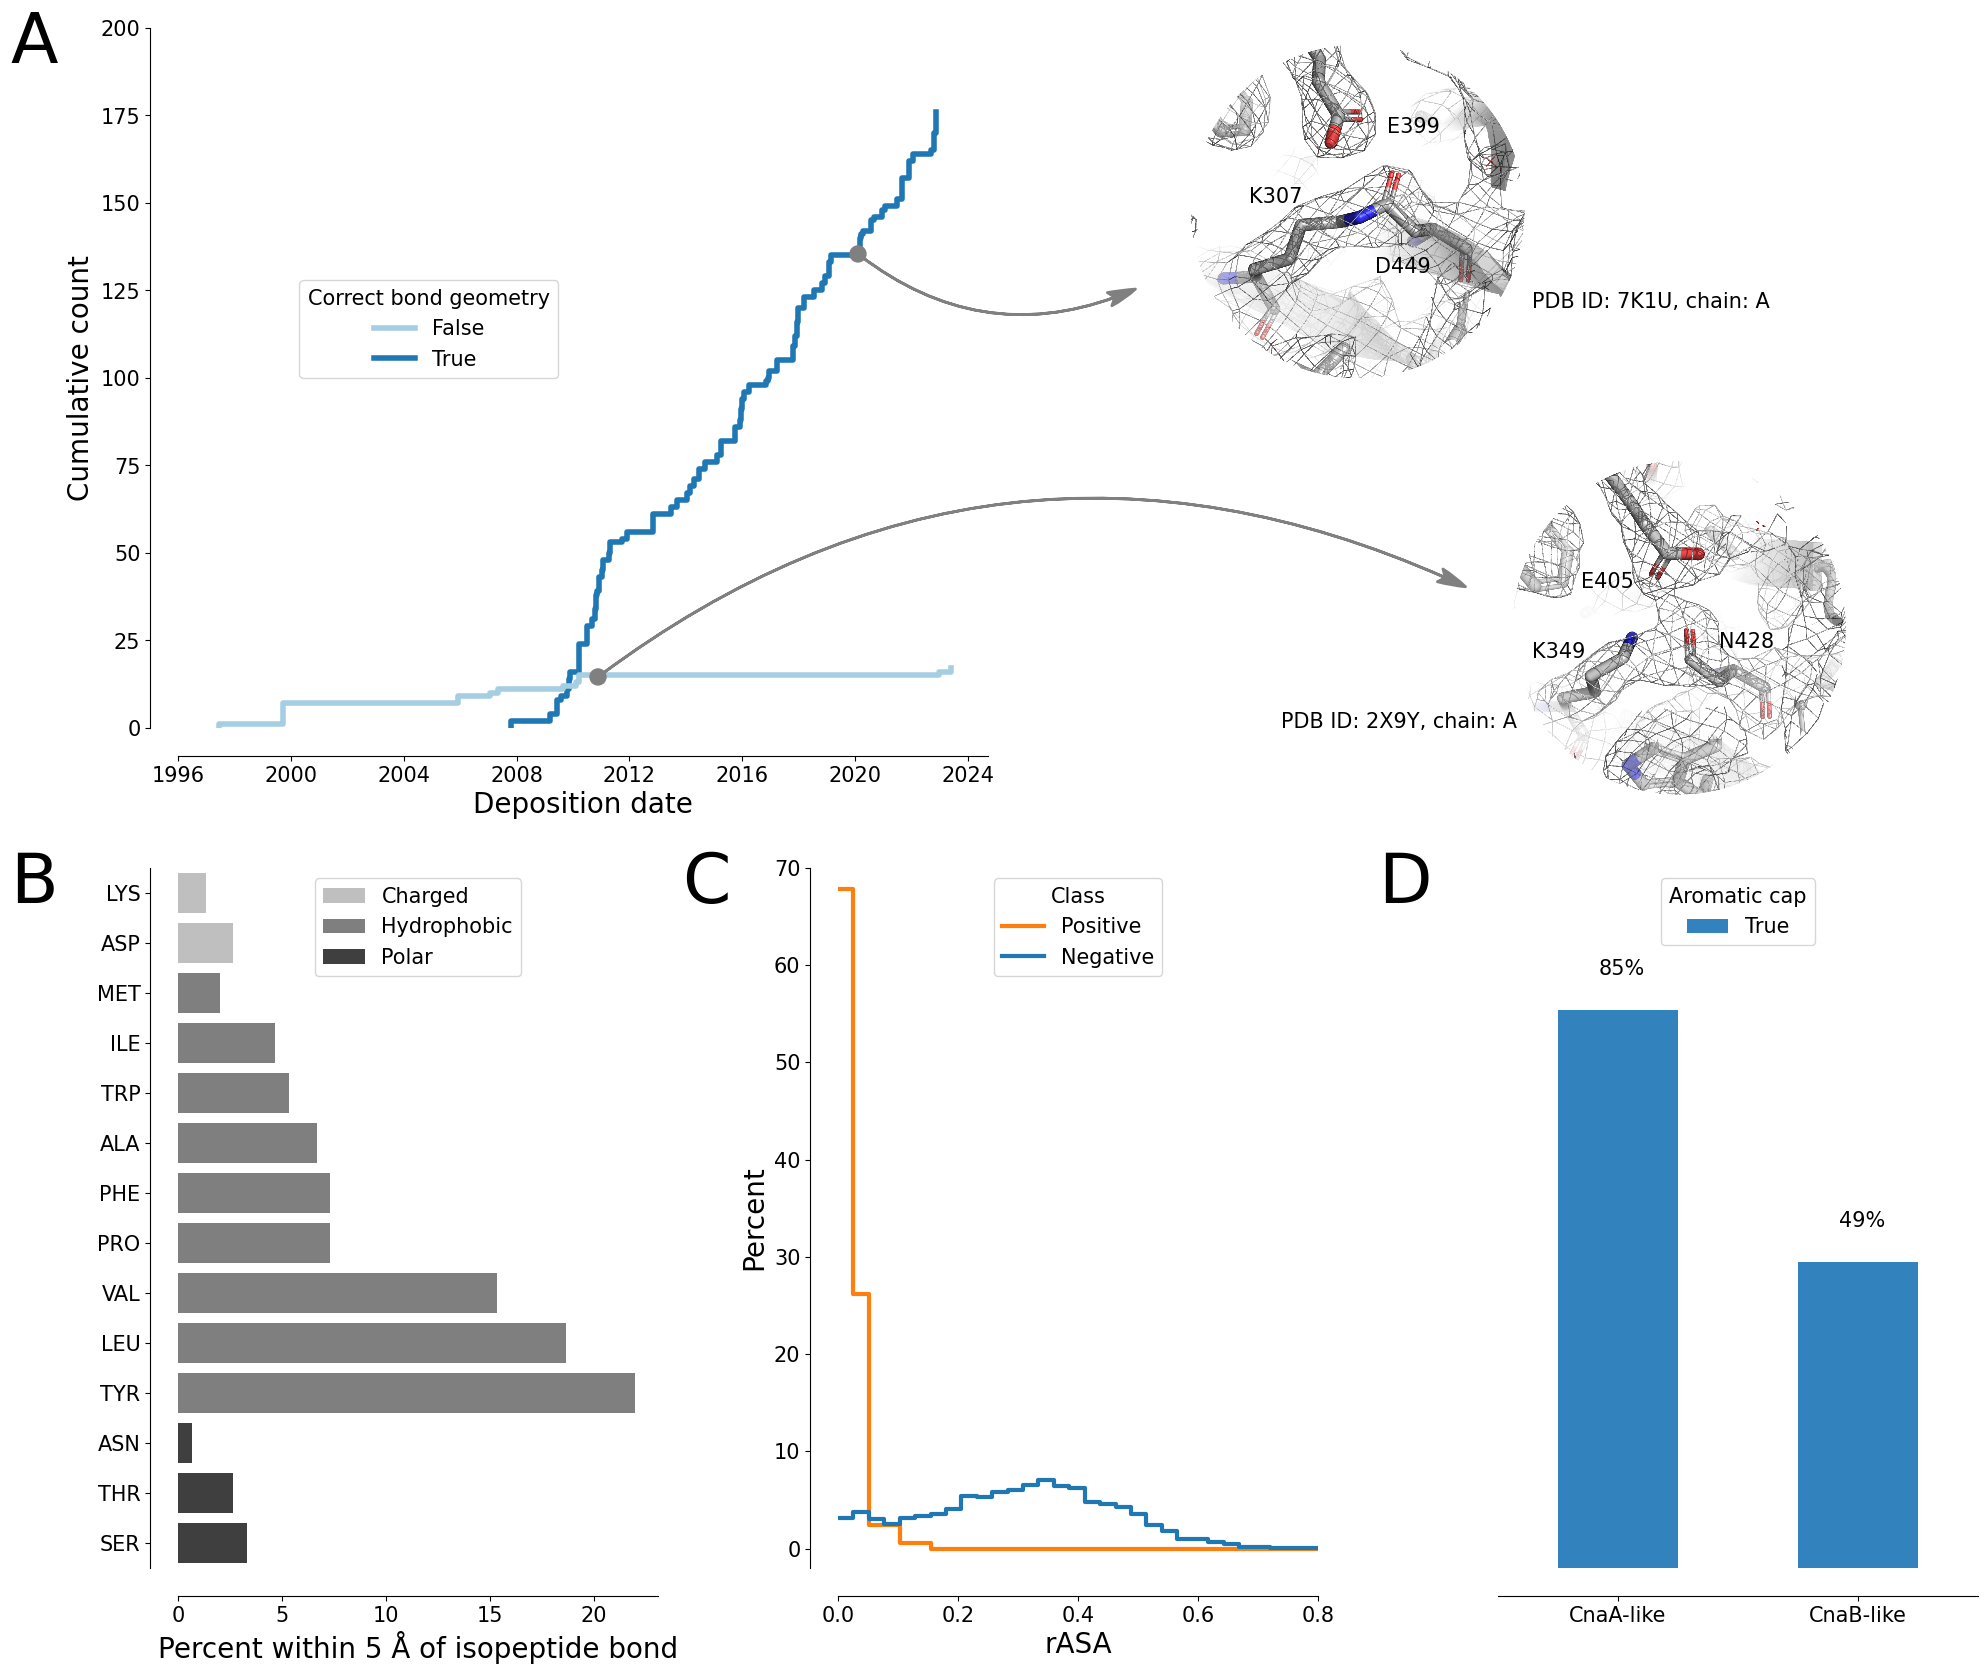

In [17]:
fig = plt.figure(figsize=[20, 20])
gs = gridspec.GridSpec(nrows=2, ncols=6, figure=fig, width_ratios=[1, 1, 1, 1, 1, 1 ])

# Make plots spanning multiple axes
ax1 = fig.add_subplot(gs[0, :3])
ax2 = fig.add_subplot(gs[0, 3:])
ax3 = fig.add_subplot(gs[1, :2])
ax4 = fig.add_subplot(gs[1, 2:4])
ax5 = fig.add_subplot(gs[1, 4:6]) 

# 1
ax = ax1
plot_df = df[df["Is bonded"] == True].rename(columns={"Assigned bond": "Correct bond geometry"})
g=sns.ecdfplot(data=plot_df, palette="Paired", 
      x="deposition_date", stat="count", hue="Correct bond geometry", ax=ax, lw=4)
sns.move_legend(g, (.15, .5))
labels = [t.get_text() for t in ax.get_xticklabels()]
positions = [t.get_position()[0] for t in ax.get_xticklabels()]
ax.set_xticks(positions, labels)
ax.set_ylim([0,200])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Deposition date")
ax.set_ylabel("Cumulative count")
sns.despine(ax=ax, offset=20)

# 2 
ax = ax2
ax.axis("off")
ax.set_xticks([], [])
ax.set_yticks([], [])

# im 1
arr_img = plt.imread("tmp/2x9y_349_405_428_cut.png")
im = OffsetImage(arr_img, zoom=.2)
ab = AnnotationBbox(im, xy=(0, 0), xybox=(0.3, -.1), box_alignment=(0, 0), bboxprops=dict(color="white"))
ax.add_artist(ab)
start = (0.21, 0.5555)
end = (0.645, 0.6)
style = "Fancy,tail_width=0.1,head_width=10,head_length=20"
kw = dict(arrowstyle=style, color="gray", linewidth=2)
a1 = FancyArrowPatch(start, end, alpha=1,
                     connectionstyle="arc3,rad=-0.3",
                     transform=fig.transFigure,
                     **kw)
point = Circle(start, 0.004, transform=fig.transFigure, color="grey", zorder=100)

fig.patches.append(a1)
fig.patches.append(point)
ax.text(x=0.14,y=0,s="PDB ID: 2X9Y, chain: A")
ax.text(x=0.45,y=.1,s="K349")
ax.text(x=0.51,y=.2,s="E405")
ax.text(x=0.68,y=.115,s="N428")

# im 2
arr_img = plt.imread("tmp/7k1u_307_399_449_cut.png")
im = OffsetImage(arr_img, zoom=.2)
ab = AnnotationBbox(im, xy=(0, 0), xybox=(-.1, .5), box_alignment=(0, 0), bboxprops=dict(color="white"))
ax.add_artist(ab)
start = (0.34, .767)
end = (0.48, 0.75)

style = "Fancy,tail_width=0.1,head_width=10,head_length=20"
kw = dict(arrowstyle=style, color="gray", linewidth=2)
a1 = FancyArrowPatch(start, end, alpha=1,
                     connectionstyle="arc3,rad=0.3",
                     transform=fig.transFigure,
                     **kw)
point = Circle(start, 0.004, transform=fig.transFigure, color="grey", zorder=100)

fig.patches.append(a1)
fig.patches.append(point)
ax.text(x=0.45,y=.6,s="PDB ID: 7K1U, chain: A")
ax.text(x=0.1,y=.75,s="K307")
ax.text(x=0.255,y=.65,s="D449")
ax.text(x=0.27,y=.85,s="E399")
# 3
ax = ax3
plot_df = s_df.drop_duplicates("isopep_sequence")[["res_type"]].value_counts(normalize=True).reset_index()\
          .rename(columns={"res_type": "Amino acid"})
plot_df["Amino acid type"] = plot_df["Amino acid"].map(AMINO_MAPPER)
plot_df = plot_df.sort_values(["Amino acid type", "proportion"])
plot_df["Percent"] = plot_df["proportion"].mul(100)
g = sns.barplot(plot_df, x="Percent",
                y="Amino acid",  alpha=1,
                 hue="Amino acid type", palette="binary", ax=ax)
#ax.set_title("Amino acids within 5Å of an isopeptide bond")
ax.set_xlabel("Percent within 5 Å of isopeptide bond")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("")
sns.despine(ax=ax, offset=20)
ax.legend(loc="upper center")

# 4
ax = ax4
plot_df = res_df[~res_df["mean_rASA"].isna()].sort_values("rmsd").drop_duplicates(["match_id"], keep="first")
# This is a duplicate, remove
plot_df = plot_df[~((plot_df["target"]=="5dz9_A")&(plot_df["template"]=="4z1p_A"))]
plot_df = plot_df[~((plot_df["target"]=="4z1p_A")&(plot_df["template"]=="5dz9_A"))]

sns.histplot(plot_df, x="mean_rASA", hue="true_positive", alpha=1, element="step",
             fill=False, common_norm=False, stat="percent", ax=ax, lw=3)
ax.set_xlabel("rASA")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(title='Class', labels=['Positive', 'Negative'], loc="upper center")
ax.set_ylim([-2, 70])
ax.set_xlim([0,.8])
sns.despine(ax=ax, offset=20)

# 5
# Adopt some approximate values since I am not considering hydrogens
# max pi-H distance + C-H distance
ax = ax5
dist_cutoff = 4.3+1.09
angle_cutoffs = [80, 100]
plot_df = dt_df.drop_duplicates("isopep_sequence").copy()
plot_df["Aromatic cap"] = True
plot_df.loc[(plot_df["distance_to_aro"]>dist_cutoff)&\
    ((plot_df["angle_with_aro"]<angle_cutoffs[0])|(plot_df["angle_with_aro"]>angle_cutoffs[1])), "Aromatic cap"] = False
cond1 = (plot_df["Is bonded"] == True)
cond2 = (plot_df["Interchain"] == False)
cond3 = (plot_df["Bad rotamer"] == False)
cond4 = (plot_df["Isopeptide type (see notes)"]!="Mutant")
plot_df = plot_df[cond1&cond2&cond3&cond4].groupby(["Isopeptide type (see notes)"])\
    .value_counts(["Aromatic cap"], normalize=True).reset_index()
plot_df["Percent"] = plot_df["proportion"].mul(100)

plot_df[plot_df["Aromatic cap"]==True].pivot(columns="Aromatic cap", values="Percent", index="Isopeptide type (see notes)")\
    .reindex(columns=[True], level="first")\
    .plot.bar(ax=ax, cmap="tab20c")
# Annot
y = plot_df[(plot_df["Aromatic cap"]==True)&(plot_df["Isopeptide type (see notes)"]=="CnaA-like")]["Percent"].iloc[0] + 5
ax.text(x=0-.08, y=y, s=f"{round(y)}%")
y = plot_df[(plot_df["Aromatic cap"]==True)&(plot_df["Isopeptide type (see notes)"]=="CnaB-like")]["Percent"].iloc[0] + 5
ax.text(x=1-.08, y=y, s=f"{round(y)}%")

ax.set_ylim([0,100])
#ax.set_ylabel("Percent")
ax.set_xlabel("")
plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
sns.despine(ax=ax, offset=20, left=True)
ax.set_yticks([],[])
ax.legend(loc="upper center", title="Aromatic cap")

plt.subplots_adjust(hspace=.2, wspace=1.2, left=0, right=.9)
plt.text(-6.7,215, "A", fontsize=ANNOT_FONT_SIZE)
plt.text(-6.7,95, "B", fontsize=ANNOT_FONT_SIZE)
plt.text(-3.9,95, "C", fontsize=ANNOT_FONT_SIZE)
plt.text(-1,95, "D", fontsize=ANNOT_FONT_SIZE)

plt.savefig(os.path.join(FIGURES, "f2.png"), dpi=350, bbox_inches="tight")

### Figure 3

In [8]:
import matplotlib.patches as mpatches 
from matplotlib.collections import PatchCollection

def draw_self_loop(center, radius, facecolor="Black", edgecolor='Black', theta1=-60, theta2=180, rotation=90):
    """ Adapted from https://naysan.ca/2020/07/04/how-to-draw-an-arrow-that-loops-with-matplotlib/"""
    
    # Add the ring (arc)
    rwidth = 0.005
    ring = mpatches.Wedge(center, radius, theta1, theta2, width=rwidth)
    
    # Calculate arrow cap position based on theta2
    theta2_rad = np.radians(theta2)  # Convert theta2 to radians
    x_end = center[0] + radius * np.cos(theta2_rad)
    y_end = center[1] + radius * np.sin(theta2_rad)
    
    # Convert rotation parameter to radians and add it to theta2 for the arrow orientation
    rotation_rad = np.radians(rotation)
    arrow_angle = theta2_rad + rotation_rad
    
    # Define the triangle cap at the end of the arc, with additional rotation
    offset = 0.02  # Width of the arrow cap
    left = [x_end - offset * np.cos(arrow_angle + np.pi/2), y_end - offset * np.sin(arrow_angle + np.pi/2)]
    right = [x_end + offset * np.cos(arrow_angle + np.pi/2), y_end + offset * np.sin(arrow_angle + np.pi/2)]
    bottom = [x_end + 0.05 * np.cos(arrow_angle), y_end + 0.05 * np.sin(arrow_angle)]
    arrow = plt.Polygon([left, right, bottom, left])
    
    # Add both the arc and arrow cap to a PatchCollection
    p = PatchCollection(
        [ring, arrow], 
        edgecolor=edgecolor, 
        facecolor=facecolor,
        zorder=100,
        clip_on=False
    )
    ax.add_collection(p)

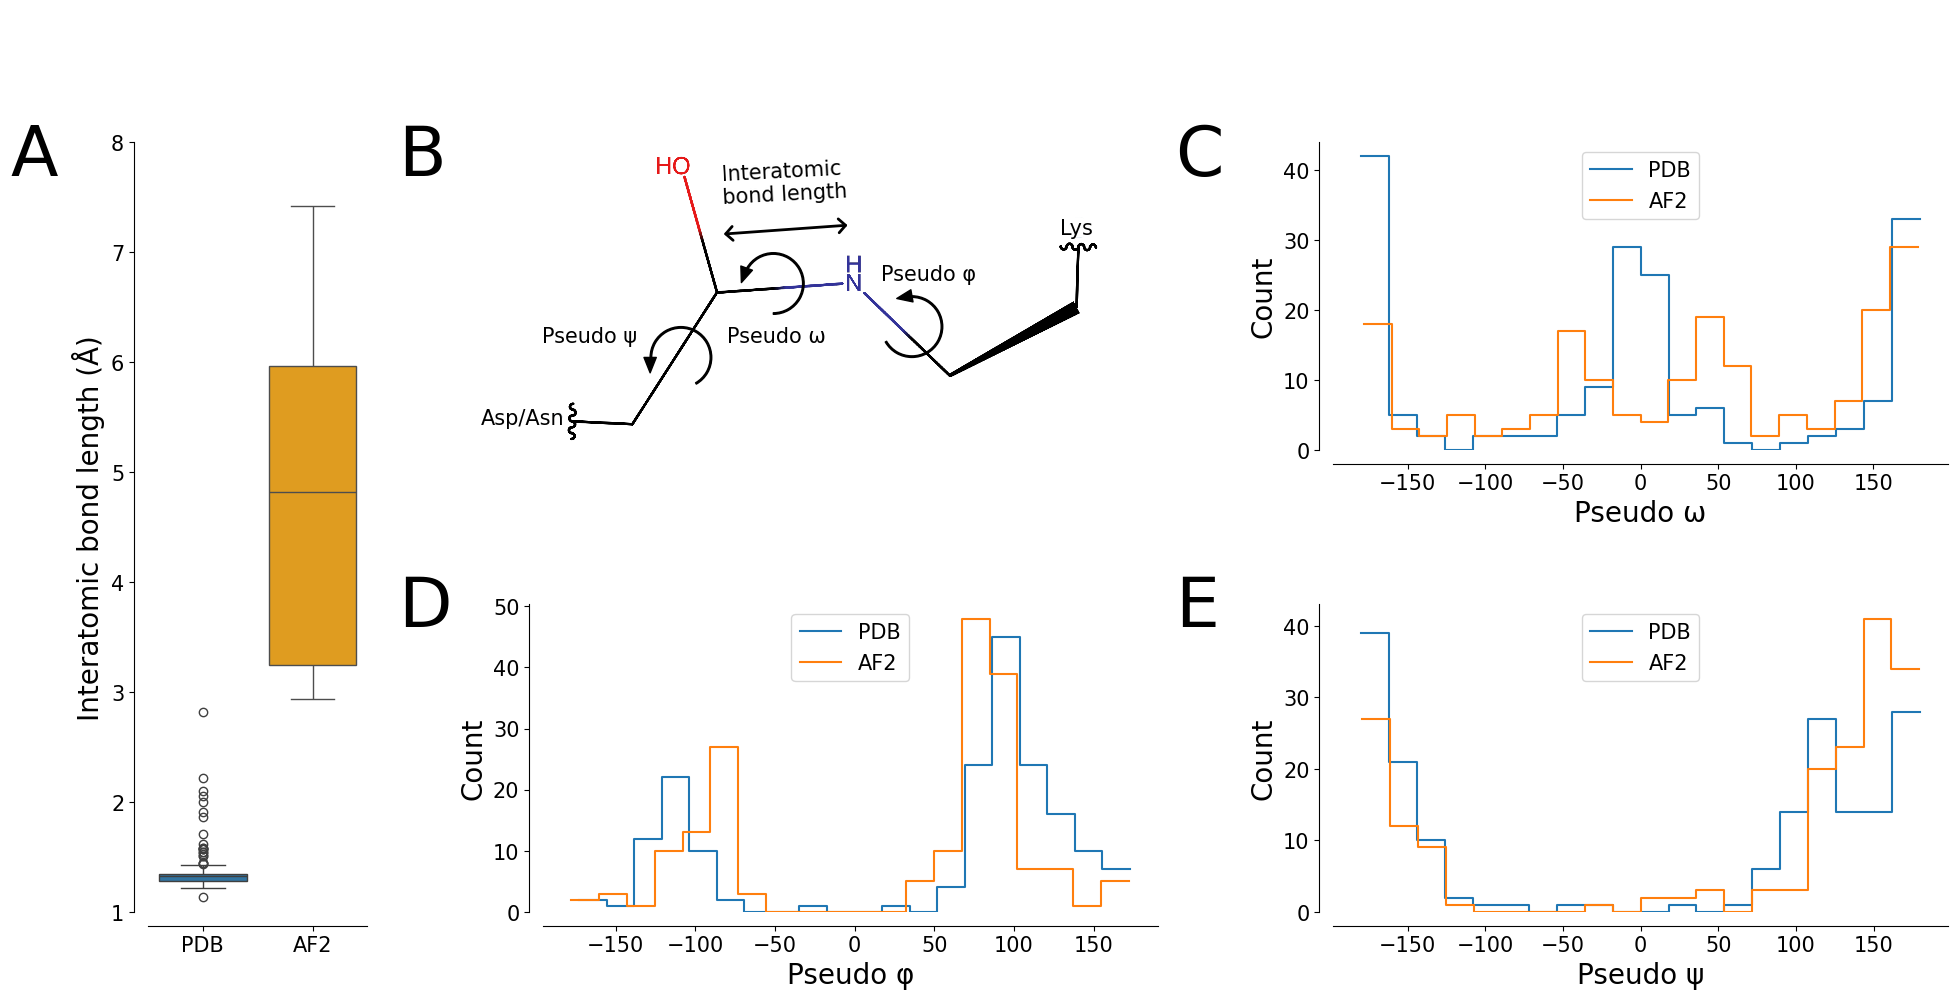

In [11]:
fig = plt.figure(figsize=[20, 10])
gs = gridspec.GridSpec(nrows=2, ncols=5, figure=fig, width_ratios=[1, 1, 1, 1, 1])

# Make plots spanning multiple axes
ax1 = fig.add_subplot(gs[:2, :1])
ax2 = fig.add_subplot(gs[0, 1:3])
ax3 = fig.add_subplot(gs[0, 3:5])
ax4 = fig.add_subplot(gs[1, 1:3])
ax5 = fig.add_subplot(gs[1, 3:5])

# 1
ax = ax1
sns.boxplot(x=1, y=dt_df["bond_length"].to_list(), ax=ax, color="C0")
sns.boxplot(x=0, y=af_df["bond_length"].to_list(), ax=ax, color="orange")
ax.set_xticks([0,1], ["PDB", "AF2"])
ax.set_ylabel("Interatomic bond length (Å)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim([1,8])
sns.despine(offset=10, ax=ax)

# 2
ax = ax2
ax.axis("off")
# Image of isopep bond
arr_img = plt.imread("tmp/isopepbond_cleaned.png")
im = OffsetImage(arr_img, zoom=.2)
ab = AnnotationBbox(im, xy=(0, 0), xybox=(-0.5, -0.4), box_alignment=(0, 0), bboxprops=dict(color="white"))
ax.add_artist(ab)

# Curved arrows and annot
ax.set_aspect('equal')
draw_self_loop(center=(-0.05, .3), radius=.1, theta1=-60, theta2=180)
draw_self_loop(center=(.25, .54), radius=.1, theta1=-90, theta2=150, rotation=100)
draw_self_loop(center=(.7, .4), radius=.1, theta1=-150, theta2=90, rotation=100)
ax.text(x=-.5, y=.35, s="Pseudo ψ")
ax.text(x=.1, y=.35, s="Pseudo ω")
ax.text(x=.6, y=.55, s="Pseudo φ")

# Bond len arrow
start_point = (0.08, 0.7)
end_point = (0.5, 0.73)
arrow = FancyArrowPatch(start_point, end_point, color="black", linewidth=2, arrowstyle="<->,head_width=5,head_length=5", 
                        zorder=10, ls="-")
ax.add_patch(arrow)
ax.text(x=.08, y=.8, s="Interatomic\nbond length", rotation=3)

# Other text
ax.text(x=-.7, y=.082, s="Asp/Asn")
ax.text(x=1.18, y=.7, s="Lys")

# 3
ax = ax3
sns.histplot(dt_df["pseudo_omega"].to_list(), ax=ax, fill=False, element="step", bins=20, label="PDB")
sns.histplot(af_df["pseudo_omega"].to_list(), ax=ax,fill=False, element="step", bins=20, label="AF2")
ax.legend(loc="upper center")
ax.set_xlabel("Pseudo ω")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
sns.despine(offset=10, ax=ax)

# 4
ax = ax4
sns.histplot(dt_df["pseudo_psi"].to_list(), ax=ax, fill=False, element="step", bins=20, label="PDB")
sns.histplot(af_df["pseudo_psi"].to_list(), ax=ax,fill=False, element="step", bins=20, label="AF2")
ax.legend(loc="upper center")
ax.set_xlabel("Pseudo φ")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
sns.despine(offset=10, ax=ax)

# 5
ax = ax5
sns.histplot(dt_df["pseudo_phi"].to_list(), ax=ax, fill=False, element="step", bins=20, label="PDB")
sns.histplot(af_df["pseudo_phi"].to_list(), ax=ax,fill=False, element="step", bins=20, label="AF2")
ax.legend(loc="upper center")
ax.set_xlabel("Pseudo ψ")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
sns.despine(offset=10, ax=ax)

plt.subplots_adjust(hspace=.5, wspace=.8, left=0, right=.9)
plt.text(-1050,103, "A", fontsize=ANNOT_FONT_SIZE)
plt.text(-800,103, "B", fontsize=ANNOT_FONT_SIZE)
plt.text(-300,103, "C", fontsize=ANNOT_FONT_SIZE)
plt.text(-800,40, "D", fontsize=ANNOT_FONT_SIZE)
plt.text(-300,40, "E", fontsize=ANNOT_FONT_SIZE)

plt.savefig(os.path.join(FIGURES, "f3.png"), dpi=350, bbox_inches="tight")

### Figure S1

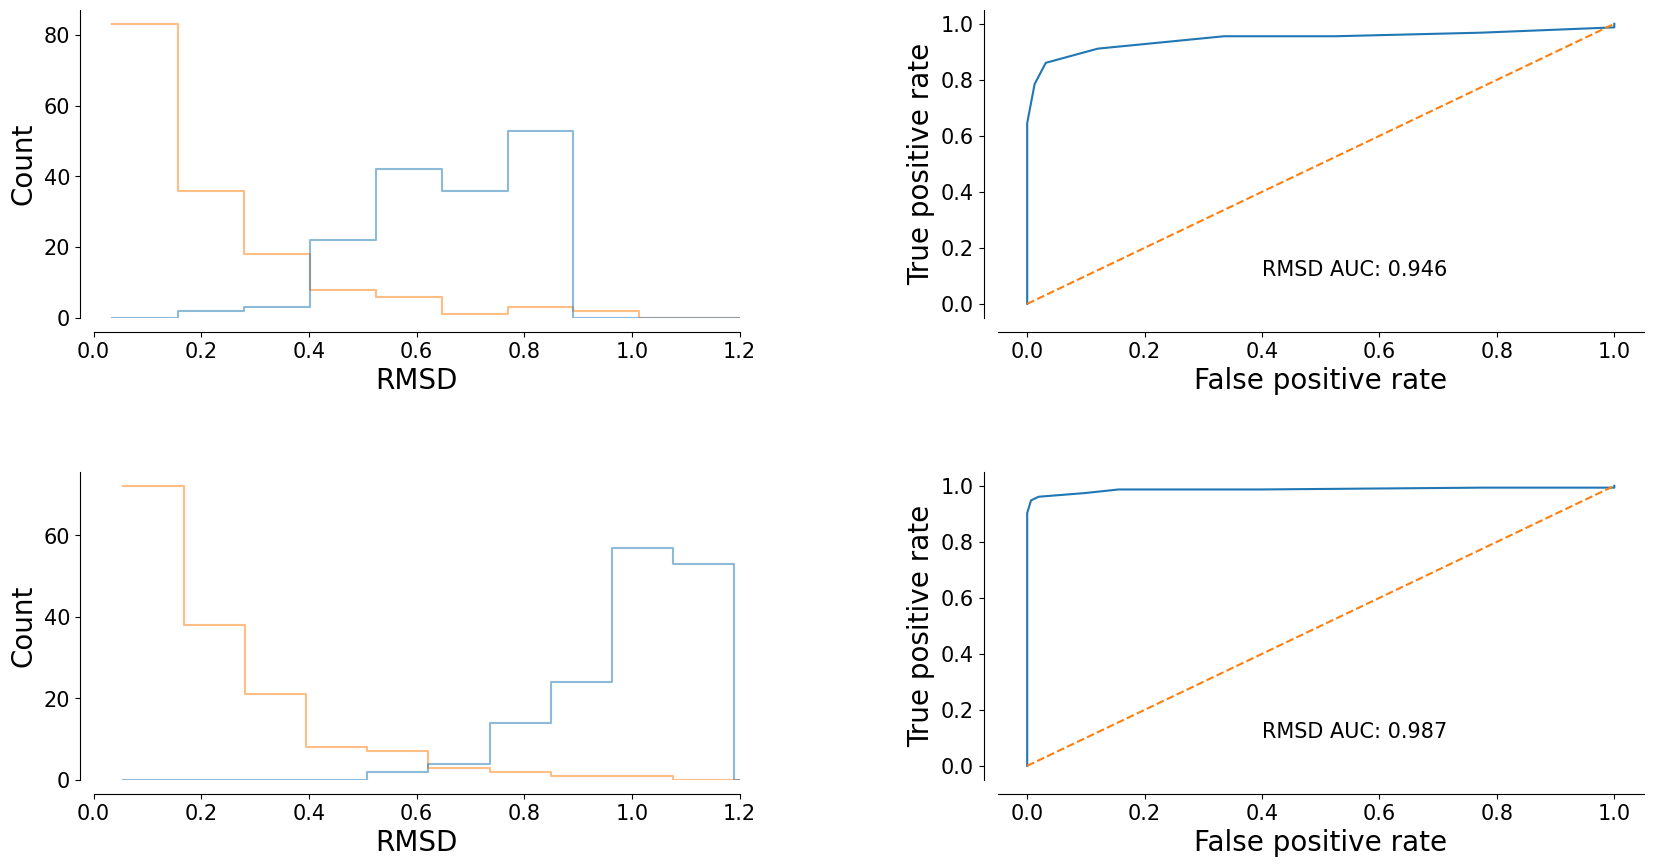

In [53]:
fig, axs = plt.subplots(figsize=[20,10], nrows=2, ncols=2)

thresholds = [i/10 for i in range(0, 100, 1)]


# 1
plot_df = pd.merge(res_df1, identity_df[identity_df["identity"]>0.3].rename(columns={"Query":"match_id", "Target":"template_id"})\
           .assign(allowed=0), on=["match_id", "template_id"], how="left").fillna(1)\
           .query('allowed==1').query('match_id!=template_id')\
           .sort_values("rmsd").drop_duplicates(["target", "match_residues"], keep="first")
# Consider only the hit with lowest rmsd (excluding self cluster matches)
plot_df = plot_df
# Create a balanced set by excluding some negatives
n_tp = len(plot_df[plot_df["true_positive"] == 1])
plot_df = pd.concat([plot_df[plot_df["true_positive"] == 1],
                     plot_df[plot_df["true_positive"] == 0].iloc[:n_tp]])

ax = axs[0,0]
plot_df = plot_df.sort_values("rmsd").drop_duplicates(["target", "match_residues"], keep="first")
sns.histplot(data = plot_df, x="rmsd", hue="true_positive", alpha=.5, ax=ax, bins=20, 
             fill=False, element="step", legend=False)
ax.set_xlabel("RMSD")
ax.set_xlim([0,1.2])

# 2
ax = axs[0,1]
x = []
y = []
for threshold in thresholds:
    cond1 = (plot_df["rmsd"] < threshold)
    cond2 = (plot_df["rmsd"] >= threshold)
    fp = len(plot_df[cond1 & (plot_df["true_positive"] == 0)])
    tp = len(plot_df[cond1 & (plot_df["true_positive"] == 1)])
    tn = len(plot_df[cond2 & (plot_df["true_positive"] == 0)])
    fn = len(plot_df[cond2 & (plot_df["true_positive"] == 1)])
    tpr = tp / (tp+fn)
    fpr = fp / (fp+tn)
    x.append(fpr)
    y.append(tpr)

ax.plot(x,y)
ax.plot(x,x, ls="--")
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.text(s=f"RMSD AUC: {round(auc(x, y), 3)}", x=0.4, y=0.1)

# 3
# res_df3 already has identity and allowed fields
plot_df = pd.merge(res_df2, identity_df[identity_df["identity"]>0.3].rename(columns={"Query":"match_id", "Target":"template_id"})\
           .assign(allowed=0), on=["match_id", "template_id"], how="left").fillna(1)\
           .query('allowed==1').query('match_id!=template_id')\
           .sort_values("rmsd").drop_duplicates(["target", "match_residues"], keep="first")

# Create a balanced set by excluding some negatives
n_tp = len(plot_df[plot_df["true_positive"] == 1])
plot_df = pd.concat([plot_df[plot_df["true_positive"] == 1],
                     plot_df[plot_df["true_positive"] == 0].iloc[:n_tp]])
ax = axs[1,0]
plot_df = plot_df.sort_values("rmsd").drop_duplicates(["target", "match_residues"], keep="first")
sns.histplot(data = plot_df, x="rmsd", hue="true_positive", alpha=.5, ax=ax, bins=20, 
             fill=False, element="step", legend=False)
ax.set_xlabel("RMSD")
ax.set_xlim([0,1.2])

# 4
ax = axs[1,1]
x = []
y = []
for threshold in thresholds:
    cond1 = (plot_df["rmsd"] < threshold)
    cond2 = (plot_df["rmsd"] >= threshold)
    fp = len(plot_df[cond1 & (plot_df["true_positive"] == 0)])
    tp = len(plot_df[cond1 & (plot_df["true_positive"] == 1)])
    tn = len(plot_df[cond2 & (plot_df["true_positive"] == 0)])
    fn = len(plot_df[cond2 & (plot_df["true_positive"] == 1)])
    tpr = tp / (tp+fn)
    fpr = fp / (fp+tn)
    x.append(fpr)
    y.append(tpr)

ax.plot(x,y)
ax.plot(x,x, ls="--")
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.text(s=f"RMSD AUC: {round(auc(x, y), 3)}", x=0.4, y=0.1)


sns.despine(offset=10)
plt.subplots_adjust(hspace=.5, wspace=.4)

